## 1. Set up

In [13]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
from dateutil.relativedelta import relativedelta
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [14]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [15]:
import gc
gc.collect()

171

## 2. Data Loading & Preprocessing

In [ ]:
data_file_path = 'TO BE FILLED IN'

### 2.1 TPA & Client

In [16]:
# Client & TPA

TPA = pd.read_excel(data_file_path + 'Copy_of_TPA_cash.xlsx',sheet_name='Sheet1')
Client = pd.read_excel(data_file_path + 'Client_info_20191118.xlsx',sheet_name='Sheet1')
# 3 Clients have duplicates records
# Client[Client['Client ID'].isin([1500,7601,2449])]
Client = Client.drop(Client.index[[0,1,497]])


Client = Client.merge(TPA,how='left',left_on='Client ID',right_on='HOST ID')
Client['TPA'] = Client['TPA_x']
Client.loc[Client['TPA_x'].isnull(),'TPA'] = Client.loc[Client['TPA_x'].isnull(),'TPA_y']
Client['TPA'] = Client['TPA'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Client.drop(['TPA_x','TPA_y','HOST ID'],axis=1,inplace = True)

In [17]:
# You might want to delete TPA, uncomment following line
# del TPA

### 2.2 Customer

In [18]:
Customer_old = pd.read_csv(data_file_path + 'Customer_Data_Request_20191121.csv')
Customer = pd.read_csv(data_file_path + 'Customer_Data_Request_20191217.csv')
# Append these 2 dataframes together
Customer = Customer_old.append(Customer,ignore_index = True)


# 2 Customer has duplicating records, we pick ClientID 2049 as their real Client but this is just a random choice
# Customer[Customer['Unique_Customer_ID']==100541023,100696306]
# Drop the duplicates customerID by index
Customer = Customer.drop(Customer.index[[72898,51730]])

# This line is self-explained
Customer = Customer.replace('.', np.nan)


# ===================== #
# Formatting conversion #
# ===================== #
def f(x):
    """
    This is a function that takes in any string format variable
    and return it as uppercase format.
    
    """
    if pd.notnull(x):
        return x.upper()
    else:
        return np.nan

Customer['Street1'] = Customer['Street1'].apply(lambda x: f(x))
Customer['Street2'] = Customer['Street2'].apply(lambda x: f(x))
Customer['City'] = Customer['City'].apply(lambda x: f(x))
Customer['Status'] = Customer['Status'].apply(lambda x: f(x))

# Convert numeric columns to float type
Customer_numeric_columns = ['Customer_Salary','Customer_Tenure']
Customer[Customer_numeric_columns] = Customer[Customer_numeric_columns].astype(float)

# Convert date format columns to datetime type
Customer_date_columns = ['Enrollment_Date','Term_Date']
Customer[Customer_date_columns] = Customer[Customer_date_columns].astype(str).apply(pd.to_datetime, format='%m/%d/%Y')

# Some data cleaning here, eliminate the customers with following cases
# Customer_Salary has NaN, 0 and '.' ~11%
# Assigned_Spending_Limit has 0 ~7%
# Customer_Tenure has NaN

# Customer = Customer[(Customer['Assigned_Spending_Limit'] != 0) & 
#                     (Customer['Customer_Salary'] != 0) & 
#                     (Customer['Customer_Salary'].notnull())&
#                     (Customer['Customer_Tenure'].notnull())]




# Merge Customer dataset with Client by Company ID/Client ID
Customer = Customer.merge(Client,how='left',left_on='Unique_Company_ID',right_on='Client ID')
Customer.head()


,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,100001115,1000,2014-02-24,6880.0,230.0,58229.0,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
1,100001120,1000,2014-02-24,6520.0,362.0,109245.0,Repeat Buyer,94 BRENTWOOD LN,NaN,VALLEY STREAM,NY,11581,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,100001141,1000,2014-02-25,10290.0,337.0,127226.0,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
3,100001158,1000,2014-02-24,5190.0,419.0,49375.0,Repeat Buyer,1036 BRADDISH AVE,NaN,BALTIMORE,MD,21216,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
4,100001169,1000,2014-02-24,7500.0,448.0,69460.0,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA


In [6]:
print('{:.0%} of Customers have Assigned_Spending_Limit == 0'.format(Customer[Customer['Assigned_Spending_Limit']==0].shape[0]/Customer.shape[0]))
print('{:.0%} of Customers have missing Customer_Salary'.format(Customer[Customer['Customer_Salary'].isnull()].shape[0]/Customer.shape[0]))
print('{:.2%} of Customers have Customer_Salary == 0'.format(Customer[Customer['Customer_Salary']==0].shape[0]/Customer.shape[0]))
print('{:.2%} of Customers have missing Customer_Tenure'.format(Customer[Customer['Customer_Tenure'].isnull()].shape[0]/Customer.shape[0]))

7% of Customers have Assigned_Spending_Limit == 0
11% of Customers have missing Customer_Salary
0.25% of Customers have Customer_Salary == 0
0.02% of Customers have missing Customer_Tenure


### 2.3 Performance Dataset

In [19]:
Perf_11 = pd.read_csv(data_file_path + 'Performance_Data_Request_20191217.csv')
Perf = pd.read_csv(data_file_path + 'Performance_Data_Request_20191204.csv')
# Deal with the column name mismatching issue before appending the 2 dataframes together
Perf_11.rename(columns={' Unique_Order_ID': 'Unique_Order_ID',
                        'Order_date': 'Order_Date'}, inplace=True)
Perf.rename(columns={'items_ordered': 'Items_Ordered',
                     'EMPSTATUS': 'Customer_Status'}, inplace=True)
# Append these 2 dataframes together
Perf = Perf.append(Perf_11, ignore_index=True)

# This line is self-explained
Perf = Perf.replace('.', np.nan)

# ===================== #
# Formatting conversion #
# ===================== #
# Convert numeric columns to float type
Perf_numeric_columns = ['Order_Amount', 'Product_Markup', 'Payments_Due', 'Current_Balance', 'Losses', 
                   'Spending_Limit_at_time_of_Order', 'Tenure_at_time_of_Order','Salary_at_time_of_Order']
Perf[Perf_numeric_columns] = Perf[Perf_numeric_columns].astype(float)

# Convert date format columns to datetime type
Perf_date_columns = ['Date_account_went_delinquent','Order_Date']
Perf[Perf_date_columns] = Perf[Perf_date_columns].astype(str).apply(pd.to_datetime,format = '%m/%d/%Y' )


# Make sure the data order is aligned with OrderID & Y-M
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format='%Y%m')
Perf = Perf.sort_values(['Unique_Order_ID', 'Year_and_Month'], ascending=[False, True])

# ======================== #
# New Columns Construction #
# ======================== #

# Create YQ and Year
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

# Create Payment_Order by Unique_Order_ID and Year_and_Month
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# Create Bad Flag - Treat 151+ and CO as BAD
Perf['Bad'] = 0
Perf.loc[Perf['Default_Status'].isin(['151+', 'Chargeoff']), 'Bad'] = 1

# Create a flag Ever_Bad to distinguish first time bad and non-first time bad
# If Ever_Bad == 1, this order is bad at the first time,
# If Ever_Bad >1, this order has been bad but not at the first time
# If Ever_Bad == 0, this order is good
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# Create 2os_loss
# Note that Orders with Default_Status == Chargeoff, the corresponding Current_Balance == 0, but Losses has valid value
# while Orders with Default_Status == 151+, the corresponding Current_Balance has valid value, but Losses == 0
# Thus, we use Losses for C/O orders and Current_Balance for 151+ orders to create 2os_loss
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status'] == 'Chargeoff',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == 'Chargeoff', 'Losses']
Perf.loc[Perf['Default_Status'] == '151+',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == '151+', 'Current_Balance']



# Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount'] != 0)]

# Merge Perf dataset with Customer by Unique_Customer_ID
Perf = Perf.merge(Customer, how='left', on='Unique_Customer_ID')

In [ ]:
# Well this chunk of code takes forever...


# import s3fs

# s3 = s3fs.S3FileSystem(anon=False)

# # Use 'w' for py3, 'wb' for py2
# with s3.open('power-purchasing/Perf_All.csv','w') as f:
#     Perf.to_csv(f)

## 3. Portfolio View - loss rate

In [21]:
#Select Performance Data after 2015
df_15 = Perf[Perf['Year']>=2015]

In [161]:
# df_15['2os_bal'] = df_15['Current_Balance']
# df_15.loc[df_15['Default_Status'] == 'Chargeoff','2os_bal'] = df_15.loc[df_15['Default_Status'] == 'Chargeoff', 'Losses']
# df_15.loc[(df_15['Default_Status'] == 'Chargeoff') & (df_15['Losses'] == 0),
#           '2os_bal'] = df_15.loc[df_15['Default_Status'] == 'Chargeoff', 'Current_Balance']
# df_15.loc[(df_15['Payment_Order'] == 1), '2os_bal'] = df_15.loc[(
#     df_15['Payment_Order'] == 1), 'Order_Amount']

In [22]:
# Monthly flow-in loss
d1 = df_15[(df_15['Bad']==1)&(df_15['Ever_Bad']<=1)].groupby('Year_and_Month').agg({'2os_loss':'sum'}).reset_index()

In [23]:
# Monthly balance of active accounts
d2 = df_15.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()

In [24]:
# Merge these two by `Year and Month`
d3 = d1.merge(d2, how='left', on='Year_and_Month')

In [25]:
d3['Year']=d3['Year_and_Month'].dt.year
d3['loss_rate'] = (d3['2os_loss']/d3['Current_Balance'])*12
d3

,Year_and_Month,2os_loss,Current_Balance,loss_rate,Year
0,2015-01-01,1534316.62,1.960824e+08,0.093898,2015
1,2015-02-01,1318131.52,1.872079e+08,0.084492,2015
2,2015-03-01,1532162.89,1.817577e+08,0.101156,2015
3,2015-04-01,1309717.23,1.766093e+08,0.088991,2015
4,2015-05-01,1365530.15,1.721193e+08,0.095204,2015
5,2015-06-01,1600823.93,1.694206e+08,0.113386,2015
6,2015-07-01,1976183.22,1.681809e+08,0.141004,2015
7,2015-08-01,1995638.12,1.708924e+08,0.140133,2015
8,2015-09-01,2014090.87,1.676917e+08,0.144128,2015
9,2015-10-01,1888123.44,1.648773e+08,0.137420,2015


In [26]:
d3.groupby('Year').agg({'loss_rate':'mean'}).reset_index()

,Year,loss_rate
0,2015,0.113289
1,2016,0.119610
2,2017,0.125140
3,2018,0.133305
4,2019,0.160766


## 4. pbads View - from 2017 to 2019

In [27]:
df_17 = Perf[Perf['Year']>=2017]

In [28]:
df_17_w_bad = df_17[df_17['Account Name'].isin(df_17[(df_17['Bad'] == 1) & (df_17['Ever_Bad'] <= 1)]['Account Name'].tolist())]

In [13]:
# Client_sub = Client[Client['Account Name'].isin(df_17_w_bad['Account Name'].unique())]

In [33]:
# Annual Flow-in Bad Customers by Client
flow_cust = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
flow_cust.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [34]:
# Annual # of Active Customers by Client
total_cust_ob = df_17_w_bad.pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
total_cust_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

### 4.1 pbads Contribution by Client

In [30]:
# Views of Client pbads from 2017 to 2019
pbads = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(values='Unique_Customer_ID', index='Account Name',columns='Year', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
# Sum up the total pbads per year and convert Client pbads to contribution percentage view
pbads.loc['Total',1:]= pbads.iloc[:,1:].sum(axis=0)
pbads.iloc[:,1:] = pbads.iloc[:,1:].fillna(0).div(pbads.iloc[-1,1:], axis=1)
# Columns rename for later 
pbads.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)
# Exclude Total from later calculation
pbads = pbads.iloc[:-1,:]

# Average pbads for 3 years
pbads['Avg_pbads'] = pbads.iloc[:,1:].mean(axis=1)
# Rank Clients by Avg_pbads and then create cumulative pbads as cum_pbads
pbads['cum_pbads'] = pbads.sort_values('Avg_pbads',ascending = False)['Avg_pbads'].cumsum()

pbads = pbads.merge(Client[['Account Name','Client ID','Active','Termination Date','Industry']],how='left',on='Account Name')

In [31]:
pbads.shape

(371, 10)

In [32]:
# Top10 pbads contribution Clients
pbads[pbads['Active']=='Y'].sort_values('Avg_pbads',ascending=False).head(10)

,Account Name,2017,2018,2019,Avg_pbads,cum_pbads,Client ID,Active,Termination Date,Industry
126,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,0.119708,0.119283,0.120148,0.119713,0.119713,2049,Y,NaT,Federal Government/Associations
331,THE HOME DEPOT,0.087102,0.075542,0.074044,0.078896,0.198609,2302,Y,NaT,Retail Trade
345,TYSON FOODS,0.035836,0.036646,0.035437,0.035973,0.282394,2149,Y,NaT,Manufacturing
95,DAVITA INC,0.030098,0.031167,0.032978,0.031414,0.313808,2250,Y,NaT,Health Care and Social Assistance
81,COMMUNITY HEALTH SYSTEMS,0.028692,0.027239,0.027289,0.027740,0.341548,2422,Y,NaT,Health Care and Social Assistance
85,COMPASS GROUP (NEW),0.000038,0.029393,0.045956,0.025129,0.366677,2496,Y,NaT,Accommodation and Food Services
290,SEANC,0.018203,0.019986,0.014726,0.017638,0.384315,2191,Y,NaT,State Government/Associations
192,KOHL'S DEPARTMENT STORES,0.018431,0.017262,0.016504,0.017399,0.401714,2225,Y,NaT,Retail Trade
3,"ADVANCE AUTO PARTS, INC.",0.016873,0.018592,0.015615,0.017027,0.418741,2218,Y,NaT,Retail Trade
361,WALGREENS FULL-TIME,0.012997,0.023819,0.013244,0.016687,0.435428,2400,Y,NaT,Retail Trade


### 4.2 pbads Rate by Client

In [36]:
# Annual pbads Rate by Client
# Calculate pbad_rate using pbads/total active customers per client 
pbads_rate = flow_cust.iloc[:,1:].fillna(0)/total_cust_ob.iloc[:,1:].fillna(0)
# Assign Client Name as a new column
pbads_rate['Account Name'] = flow_cust['Account Name']
# Calculate avg_pbads_rate over past 3 years
pbads_rate['Avg_pbads_rate'] = pbads_rate.iloc[:,:-1].mean(axis=1)
pbads_rate = pbads_rate.merge(Client[['Account Name','Client ID','Active','Termination Date','Industry']],how='left',on='Account Name')

In [37]:
# Top10 pbads rate Clients
# Note, we didn't apply [# of customer >= 100] at this sorting, but you can filter it after the later merging
pbads_rate[pbads_rate['Active']=='Y'].sort_values('Avg_pbads_rate',ascending = False).head(10)

,2017,2018,2019,Account Name,Avg_pbads_rate,Client ID,Active,Termination Date,Industry
45,0.000000,1.000000,NaN,BOEING (RETIREES),0.500000,5001,Y,NaT,Manufacturing
25,0.333333,0.166667,0.750000,"AUGEO AFFINITY MARKETING, INC",0.416667,4022,Y,NaT,"Professional, Scientific, and Technical Services"
125,0.000000,0.000000,1.000000,FEDERAL FIRST,0.333333,2854,Y,NaT,Federal Government/Associations
221,0.400000,0.500000,0.000000,MERCER MARKETPLACE,0.300000,2406,Y,NaT,"Professional, Scientific, and Technical Services"
293,0.210117,0.360544,0.204620,SERCO,0.258427,2351,Y,NaT,"Professional, Scientific, and Technical Services"
123,0.230769,0.363636,0.166667,FAZOLI'S SYSTEM MGMT,0.253691,2254,Y,NaT,Accommodation and Food Services
226,0.254902,0.200000,0.263158,MMC INC,0.239353,2278,Y,NaT,Administrative and Support
10,0.262195,0.219718,0.232353,"ALPHASTAFF, INC.",0.238089,2221,Y,NaT,"Professional, Scientific, and Technical Services"
272,0.194153,0.287979,0.213668,REGIS CORPORATION,0.231934,2402,Y,NaT,Other Services (except Public Administration)
302,0.108108,0.230769,0.279070,SPIRE HOSPITALITY,0.205982,2461,Y,NaT,Administrative and Support


### 4.3 NoPay pbads Rate by Client

In [38]:
# How to create NoPay_Flag
# for each OrderID, get the intial balance and it's C/O balance, if they're the same, then it's treated as NoPay 

Initial_bal = Perf.groupby('Unique_Order_ID').head(1)
CO_bal = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)]

# Merge above two dfs to compare balance
CO_new = CO_bal[['Unique_Order_ID','Unique_Customer_ID','2os_loss','Year','Account Name']].merge(Initial_bal[['Unique_Order_ID','Current_Balance']], how = 'left', on='Unique_Order_ID')

# Note that the criteria here is using 95%~105% of intial balance range, because when an order chargeoff,
# the 2os_loss could be very similar to initial balance but with a <= $1 difference, we should take this issue into consideration
CO_new['NoPay_Flag'] = CO_new.apply(lambda x: 1 if (0.95 * x['Current_Balance'] <= x['2os_loss']) & (1.05 * x['Current_Balance'] >= x['2os_loss']) else 0, axis=1)
CO_new['NoPay_Flag'].value_counts()

0    211233
1     30002
Name: NoPay_Flag, dtype: int64

In [39]:
# Annual Flow-in NoPay pbads by Client
NoPay_pbads = CO_new[CO_new['NoPay_Flag']==1].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
NoPay_pbads.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [41]:
# Some Clients don't have NoPay Customers, so we exclude them here before calculating the NoPay Rate
total_cust_ob_sub = total_cust_ob[total_cust_ob['Account Name'].isin(NoPay_pbads['Account Name'].tolist())]

In [43]:
# Annual NoPay pbads Rate by Client
NoPay_rate = NoPay_pbads.sort_values('Account Name').iloc[:,1:].fillna(0)/total_cust_ob_sub.reset_index(drop=True).sort_values('Account Name').iloc[:,1:].fillna(0)
NoPay_rate['Account Name'] = NoPay_pbads.sort_values('Account Name')['Account Name']

# Avg_NoPay_rate over the past 3 years
NoPay_rate['Avg_NoPay_rate'] = NoPay_rate.iloc[:,:-1].mean(axis=1)
NoPay_rate = NoPay_rate.merge(Client[['Account Name','Client ID','Active','Termination Date','Industry']],how='left',on='Account Name')

In [45]:
# Top10 NoPay pbads rate Clients
# Note, we didn't apply [# of customer >= 100] at this sorting, but you can filter it after the later merging
NoPay_rate[NoPay_rate['Active']=='Y'].sort_values('Avg_NoPay_rate',ascending = False).head(10)

,2017,2018,2019,Account Name,Avg_NoPay_rate,Client ID,Active,Termination Date,Industry
19,0.111111,0.000000,0.250000,"AUGEO AFFINITY MARKETING, INC",0.120370,4022,Y,NaT,"Professional, Scientific, and Technical Services"
291,NaN,NaN,0.105263,THE MECHANICS BANK,0.105263,2555,Y,NaT,Finance and Insurance
254,0.046693,0.092971,0.072607,SERCO,0.070757,2351,Y,NaT,"Professional, Scientific, and Technical Services"
194,0.200000,0.000000,0.000000,MERCER MARKETPLACE,0.066667,2406,Y,NaT,"Professional, Scientific, and Technical Services"
53,0.000000,0.146341,0.027027,CAPSTONE RESTAURANT GROUP,0.057789,2466,Y,NaT,Real Estate and Rental and Leasing
112,0.076923,0.090909,0.000000,FEDERAL MANAGERS ASSOCIATION,0.055944,2458,Y,NaT,Federal Government/Associations
235,0.039162,0.054161,0.071485,REGIS CORPORATION,0.054936,2402,Y,NaT,Other Services (except Public Administration)
9,0.051829,0.042254,0.047059,"ALPHASTAFF, INC.",0.047047,2221,Y,NaT,"Professional, Scientific, and Technical Services"
263,0.027027,0.038462,0.069767,SPIRE HOSPITALITY,0.045085,2461,Y,NaT,Administrative and Support
44,0.047067,0.042857,0.044876,C&S WHOLESALE GROCERS,0.044933,2425,Y,NaT,Wholesale Trade


In [ ]:
# =========================================================================================== #
# If you want to combine all above pbads related results together and output as one dataframe #
# =========================================================================================== #

In [124]:
prefix = 'pbads_contrib_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
pbads.rename(columns = dict(new_names), inplace=True)

In [125]:
prefix = 'pbads_rate_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
pbads_rate.rename(columns = dict(new_names), inplace=True)

In [126]:
prefix = 'NoPay_rate_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
NoPay_rate.rename(columns = dict(new_names), inplace=True)

In [127]:
prefix = 'num_of_active_customers_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
total_cust_ob.rename(columns = dict(new_names), inplace=True)

In [144]:
data_frames = [pbads, pbads_rate, NoPay_rate]

In [145]:
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['Account Name','Client ID','Active','Termination Date'],
                                            how='outer'), data_frames)


In [147]:
# Take total_cust_ob out for merging is because it only have one merging key - Account Name
df_merged = df_merged.merge(total_cust_ob, how='left',on='Account Name')
df_merged

,Account Name,pbads_contrib_2017,pbads_contrib_2018,pbads_contrib_2019,Avg_pbads,cum_pbads,Client ID,Active,Termination Date,pbads_rate_2017,pbads_rate_2018,pbads_rate_2019,Avg_pbads_rate,NoPay_rate_2017,NoPay_rate_2018,NoPay_rate_2019,Avg_NoPay_rate,num_of_active_customers_2017,num_of_active_customers_2018,num_of_active_customers_2019
0,"7-ELEVEN, INC.",0.000456,0.000190,0.000178,0.000275,0.986889,5002,Y,NaT,0.210526,0.136364,0.166667,0.171186,0.087719,0.000000,0.000000,0.029240,57.0,44.0,36.0
1,ABINGTON HEALTH,0.000532,0.000443,0.000000,0.000325,0.982181,2362,Consolidated,2018-09-28,0.325581,0.538462,0.000000,0.288014,0.116279,0.115385,0.000000,0.077221,43.0,26.0,3.0
2,ACTIVE MILITARY,0.000000,0.000000,0.000030,0.000010,0.999990,1302,Terminated,2015-06-15,0.000000,0.000000,0.500000,0.166667,NaN,NaN,NaN,NaN,3.0,3.0,2.0
3,"ADVANCE AUTO PARTS, INC.",0.016874,0.018592,0.015615,0.017027,0.418739,2218,Y,NaT,0.120587,0.151133,0.143989,0.138570,0.057849,0.020340,0.023497,0.033895,3682.0,3884.0,3660.0
4,AECOM,0.002090,0.002597,0.002696,0.002461,0.839442,2439,Y,NaT,0.086751,0.119186,0.126565,0.110834,0.047319,0.024709,0.013908,0.028645,634.0,688.0,719.0
5,AFNI,0.001292,0.001014,0.000978,0.001095,0.931652,4028,Y,NaT,0.163462,0.147465,0.154930,0.155286,0.100962,0.009217,0.014085,0.041421,208.0,217.0,213.0
6,ALABAMA STATE EMPLOYEES ASSOCIATION,0.001900,0.001204,0.001215,0.001440,0.906989,2048,Y,NaT,0.066667,0.049608,0.052767,0.056347,0.042667,0.009138,0.011583,0.021129,750.0,766.0,777.0
7,"ALERE, INC.",0.000418,0.000475,0.000148,0.000347,0.981172,2352,Terminated,2017-12-31,0.108911,0.205479,0.250000,0.188130,0.049505,0.041096,0.000000,0.030200,101.0,73.0,20.0
8,ALLIANCE RESIDENTIAL COMPANY,0.000418,0.000222,0.000000,0.000213,0.989734,2259,Terminated,2017-09-17,0.103774,0.152174,0.000000,0.085316,0.047170,0.000000,0.000000,0.015723,106.0,46.0,2.0
9,ALLINA HOSPITALS & CLINICS,0.001786,0.001805,0.002015,0.001869,0.877015,2206,Y,NaT,0.073552,0.083947,0.100443,0.085981,0.032864,0.017673,0.019202,0.023246,639.0,679.0,677.0


In [148]:
# df_merged.to_csv('../data/Pbads_view.csv',index = False)

In [ ]:
# =========================================================================================== #

### 4.4 pbads Rate vs NoPay pbads Rate - by Year
 - Well technically, I should have combined these 3 dataframes together, but instead of doing it here, I just copied them to my local Excel sheet to calculate the pbads rate and NoPay rate

In [46]:
# NoPay pbads by Year
CO_new[CO_new['NoPay_Flag']==1].groupby('Year').agg({'Unique_Customer_ID':'nunique'}).reset_index()

,Year,Unique_Customer_ID
0,2017,5360
1,2018,7169
2,2019,8714


In [47]:
# pbads by Year
df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].groupby('Year').agg({'Unique_Customer_ID':'nunique'}).reset_index()

,Year,Unique_Customer_ID
0,2017,26688
1,2018,31779
2,2019,33886


In [48]:
# Total Active Customers by Year
df_17_w_bad.groupby('Year').agg({'Unique_Customer_ID':'nunique'}).reset_index()

,Year,Unique_Customer_ID
0,2017,306597
1,2018,335316
2,2019,324783


### 4.5 Avg Customer Tenure and Salary for Top4 CO contribution Clients

In [160]:
# Here are the top4 CO pbads contribution Clients
Client[Client['Client ID'].isin([2049,2302,2149,2250])][['Account Name','Client ID']]

,Account Name,Client ID
6,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,2049
73,TYSON FOODS,2149
184,THE HOME DEPOT,2302
288,DAVITA INC,2250


*===============================================================================================================*
						 FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY
*===============================================================================================================*


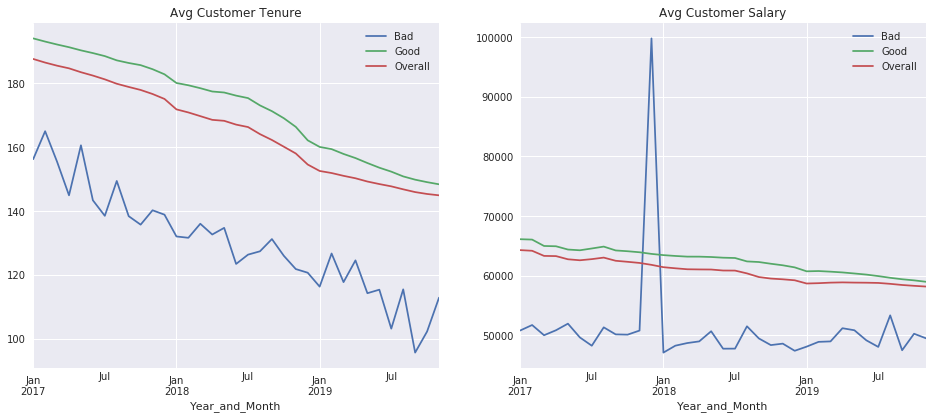

*===============================================================================================================*
						 THE HOME DEPOT
*===============================================================================================================*


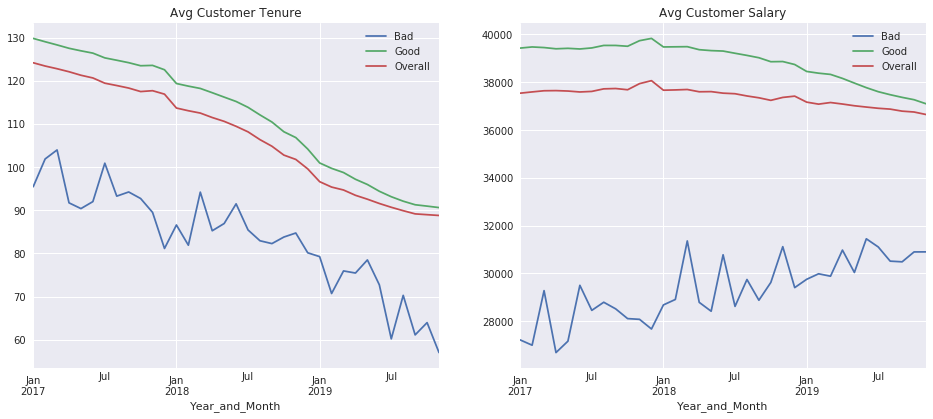

*===============================================================================================================*
						 TYSON FOODS
*===============================================================================================================*


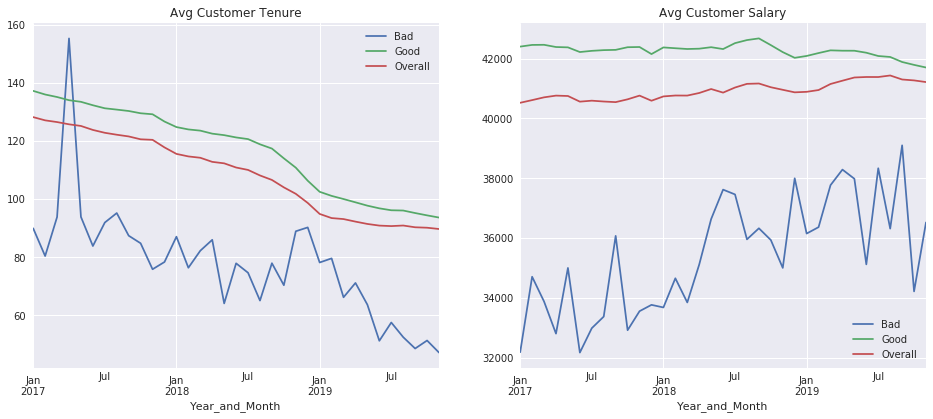

*===============================================================================================================*
						 DAVITA INC
*===============================================================================================================*


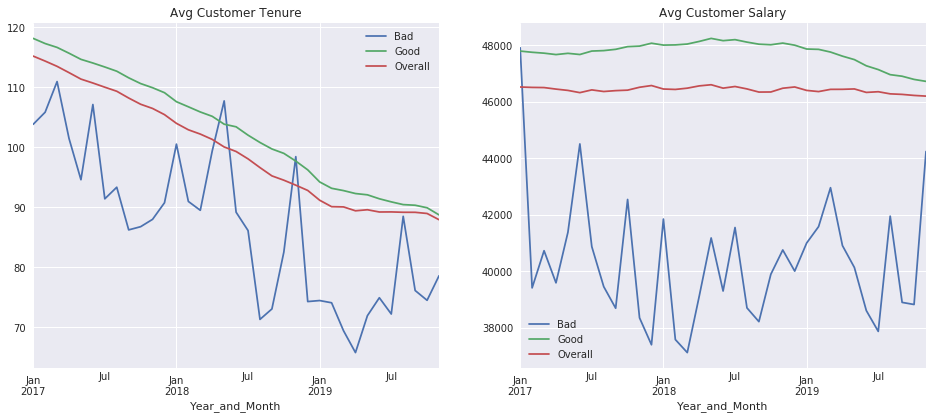

In [37]:
for client_id in [2049,2302,2149,2250]:
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
    plt.subplots_adjust(left = 0.125,
                        right = 0.9,
                        bottom = 0.1,
                        top = 0.9,
                        wspace = 0.2,
                        hspace = 0.4)
    df = df_17[df_17['Unique_Company_ID']==client_id]
    df_bad = df[(df['Bad']==1) & (df['Ever_Bad']<=1)]
    df_good = df.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)

    acct_name = Client[Client['Client ID']==client_id]['Account Name'].values[0]
    print('*===============================================================================================================*')
    print('\t\t\t\t\t\t',acct_name)
    print('*===============================================================================================================*')

    df_bad.groupby('Year_and_Month').agg({'Tenure_at_time_of_Order':'mean'}).plot(ax=axes[0])
    df_good.groupby('Year_and_Month').agg({'Tenure_at_time_of_Order':'mean'}).plot(ax=axes[0])
    df.groupby('Year_and_Month').agg({'Tenure_at_time_of_Order':'mean'}).plot(ax=axes[0])
    
    axes[0].legend(['Bad','Good','Overall'])
    axes[0].set_title('Avg Customer Tenure')

    df_bad.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1])
    df_good.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1])
    df.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1])
    axes[1].legend(['Bad','Good','Overall'])
    axes[1].set_title('Avg Customer Salary')
    plt.show()

In [17]:
# =================================================================== #
# If you want output data to generate above views on your local Excel #
# =================================================================== #

# for client_id in [2049,2302,2149,2250]:
#     df = df_17[df_17['Unique_Company_ID']==client_id]
#     df.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/{}.csv'.format(client_id),index = False)
#     df_bad = df[(df['Bad']==1) & (df['Ever_Bad']<=1)]
#     df_good = df.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)
#     df_bad.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/{}_bad.csv'.format(client_id),index = False)
#     df_good.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/{}_good.csv'.format(client_id),index = False)
    

## 5. Client Portfolio View - Loss Rate & Loss Contribution

In [49]:
# Annual Flow Loss by Client
flow_loss = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='2os_loss', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_loss.csv')
flow_loss.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [12]:
# Annual Flow Bad Customers by Client
# flow_cust = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
#     values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# #.to_csv('../data/Client_bad_cust.csv')
# flow_cust.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [50]:
# Annual Flow Bad Orders by Client
flow_ord = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
#.to_csv('../data/Client_bad_order.csv')
flow_ord.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [51]:
# Annual On Book $Order Amount by Client
total_amt_ob = df_17_w_bad.groupby(['Year', 'Unique_Order_ID']).head(1).pivot_table(
    values='Order_Amount', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/client_annual_ob_vol.csv')
total_amt_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [52]:
# Annual On Book # of Orders by Client
total_ord_ob = df_17_w_bad.pivot_table(
    values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_order.csv')
total_ord_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [92]:
# Annual On Book # of Customers by Client
# total_cust_ob = df_17_w_bad.pivot_table(
#     values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# # .to_csv('../data/Client_annual_cust.csv')
# total_cust_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [65]:
# Annual Loss Contribution by Client
loss_contrib = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Account Name',columns='Year', aggfunc='sum',margins = True).reset_index().rename_axis(None, axis=1).iloc[:,:-1]
# Convert individual loss to loss contribution(percentage to total loss)
loss_contrib.iloc[:,1:] = loss_contrib.iloc[:,1:].div(loss_contrib.iloc[-1,1:], axis=1)
loss_contrib.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)
# Exclude the final row, which it the total loss for each year
loss_contrib = loss_contrib.iloc[:-1,:]

In [67]:
loss_contrib['Avg_loss_contrib'] = loss_contrib.iloc[:,1:].mean(axis=1)
loss_contrib['cum_loss_contrib'] = loss_contrib.sort_values('Avg_loss_contrib',ascending = False)['Avg_loss_contrib'].cumsum()
loss_contrib = loss_contrib.merge(Client[['Account Name','Client ID','Active','Termination Date']],how='left',on='Account Name')

In [68]:
# Top 10 loss contribution Clients
loss_contrib[loss_contrib['Active']=='Y'].sort_values('Avg_loss_contrib',ascending = False).head(10)

,Account Name,2017,2018,2019,Avg_loss_contrib,cum_loss_contrib,Client ID,Active,Termination Date
126,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,0.168128,0.164981,0.168771,0.167293,0.167293,2049,Y,NaT
331,THE HOME DEPOT,0.043226,0.038487,0.037437,0.039716,0.263074,2302,Y,NaT
95,DAVITA INC,0.038936,0.038561,0.037612,0.038369,0.301443,2250,Y,NaT
345,TYSON FOODS,0.034250,0.033013,0.031746,0.033003,0.334446,2149,Y,NaT
81,COMMUNITY HEALTH SYSTEMS,0.028057,0.030363,0.029396,0.029272,0.363718,2422,Y,NaT
290,SEANC,0.019785,0.022902,0.016108,0.019598,0.383316,2191,Y,NaT
192,KOHL'S DEPARTMENT STORES,0.017150,0.016626,0.017249,0.017009,0.400325,2225,Y,NaT
57,CALIFORNIA STATE EMPLOYEES ASSOCIATION,0.015650,0.016053,0.018354,0.016686,0.417010,2183,Y,NaT
98,"DELTA AIR LINES, INC.",0.017237,0.014954,0.015021,0.015738,0.432748,2238,Y,NaT
11,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES,0.018089,0.016055,0.012171,0.015438,0.448186,2047,Y,NaT


In [10]:
# These are the top 13 client ID
# [2049, 2302, 2250, 2149, 2422, 2191, 2225, 2183, 2238, 2047, 2496, 2218, 2400]

In [91]:
avg_bal_ob = df_17_w_bad.pivot_table(values='Current_Balance', index='Account Name',
                        columns='Year_and_Month', aggfunc='sum').reset_index().rename_axis(None, axis=1)
# avg_bal_ob.iloc[:,1:3] = avg_bal_ob.iloc[:,1:3]/12
# avg_bal_ob.iloc[:,3:] = avg_bal_ob.iloc[:,3:]/11
# avg_bal_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [92]:
avg_bal_ob

,Account Name,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00
0,"7-ELEVEN, INC.",19332.61,18503.36,18213.94,19325.72,18809.60,18033.08,16907.89,15200.80,16461.48,13577.92,17530.67,20959.16,1.970588e+04,1.910523e+04,16524.87,14891.92,1.294919e+04,11286.19,1.090095e+04,1.105045e+04,1.009534e+04,1.017307e+04,1.137372e+04,1.568283e+04,1.517297e+04,13033.89,11536.61,1.110278e+04,9326.74,8275.24,8795.47,7736.96,7694.45,7917.61,9079.79
1,ABINGTON HEALTH,49848.53,41763.94,40291.35,39176.09,39871.53,36588.78,41324.42,41148.30,40418.23,39611.74,40465.22,34328.87,3.397875e+04,3.072943e+04,22726.43,17041.81,1.665789e+04,15630.51,1.189444e+04,5.656230e+03,3.501370e+03,3.501370e+03,3.305300e+02,2.977000e+02,2.500600e+02,250.06,250.06,2.024200e+02,202.42,202.42,202.42,202.42,202.42,202.42,533.13
2,ACTIVE MILITARY,3081.92,2941.33,2660.15,2660.15,2519.34,2238.16,2238.16,2047.57,2438.05,2390.23,2949.40,5377.12,5.282580e+03,5.077260e+03,2897.50,2802.96,3.728320e+03,3321.76,3.136760e+03,2.637700e+03,2.452910e+03,2.204950e+03,2.723600e+03,2.450160e+03,2.370800e+03,2021.94,1673.08,1.403580e+03,1102.97,1000.64,721.95,390.64,254.04,0.00,NaN
3,"ADVANCE AUTO PARTS, INC.",2668615.67,2569061.47,2383698.48,2520768.05,2380035.94,2559078.58,2461290.71,2478339.96,2341138.72,2371804.82,2849564.65,3180298.39,3.234989e+06,2.966863e+06,2926151.78,2728409.91,2.767602e+06,2714420.71,2.718308e+06,2.764950e+06,2.703857e+06,2.611812e+06,2.915637e+06,3.335323e+06,3.418611e+06,3224121.96,3093364.87,2.762488e+06,2728622.10,2679781.94,2650164.72,2530571.70,2693781.71,2532549.05,2846263.01
4,AECOM,544493.12,439348.03,358199.02,387699.78,419472.80,480911.55,492241.38,501808.51,487815.29,494588.98,665636.64,836958.19,8.021305e+05,7.773793e+05,753745.31,723546.57,7.024126e+05,686032.23,6.452274e+05,6.528837e+05,6.427898e+05,6.359188e+05,7.024828e+05,7.838124e+05,7.591308e+05,712597.97,686685.28,6.784597e+05,659753.57,672592.97,646516.09,621399.54,624109.78,632023.55,669765.85
5,AFNI,131817.99,123543.67,117829.73,115162.17,110803.61,102508.66,100588.43,96658.37,92090.81,92232.87,105472.64,129399.82,1.286265e+05,1.305326e+05,125442.44,112861.00,1.173435e+05,114718.44,1.149290e+05,1.111437e+05,1.060485e+05,1.029254e+05,1.091151e+05,1.333466e+05,1.198601e+05,115469.63,108279.93,1.089908e+05,101350.91,98285.14,105922.82,103610.02,101238.14,102252.43,120115.78
6,ALABAMA STATE EMPLOYEES ASSOCIATION,465369.35,436364.18,412734.81,405888.92,393110.39,390999.97,395503.11,407300.77,394473.08,381886.49,407032.30,478391.81,5.062102e+05,4.373250e+05,432688.58,424390.03,4.402600e+05,417685.36,4.330760e+05,4.525507e+05,4.427786e+05,4.622883e+05,5.104065e+05,6.086697e+05,5.974595e+05,571377.13,540519.59,5.241194e+05,531127.97,510148.53,581952.67,534839.50,533706.70,513666.76,569349.07
7,"ALERE, INC.",84672.19,77076.72,76908.15,74638.34,70244.57,62691.34,65130.26,68778.99,75356.35,78764.92,87915.94,107764.79,9.595762e+04,8.455919e+04,74282.44,58754.39,4.744576e+04,38183.35,2.904524e+04,2.141324e+04,1.548208e+04,1.162700e+04,3.719140e+03,2.611230e+03,1.969960e+03,753.00,742.02,4.376000e+02,437.60,414.18,207.87,169.32,169.32,0.49,0.49
8,ALLIANCE RESIDENTIAL COMPANY,87503.84,76306.75,75084.37,74202.42,83014.10,74733.87,76646.07,69432.84,59352.35,48419.35,38910.27,30940.80,2.892673e+04,2.068660e+04,12077.81,10607.98,7.472990e+03,5136.08,3.368500e+03,1.429020

In [93]:
# Monthly Flow Loss by Client
flow_loss_monthly = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='2os_loss', index='Account Name', columns='Year_and_Month', aggfunc='sum').reset_index().rename_axis(None,axis=1)

# flow_loss.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [94]:
# Annual Loss Rate by Client
loss_rate = flow_loss_monthly.iloc[:,1:].fillna(0)/avg_bal_ob.iloc[:,1:].fillna(0)
loss_rate['Account Name'] = flow_loss['Account Name']
loss_rate['Avg_loss_rate'] = loss_rate.iloc[:,:-1].mean(axis=1)
loss_rate = loss_rate.merge(Client[['Account Name','Client ID','Active','Termination Date']],how='left',on='Account Name')

In [99]:
# Create yearly loss rate, we only have 11 months in 2019
loss_rate['2017'] = loss_rate.iloc[:,:12].sum(axis=1)
loss_rate['2018'] = loss_rate.iloc[:,12:24].sum(axis=1)
loss_rate['2019'] = loss_rate.iloc[:,24:35].sum(axis=1)/11*12

In [103]:
# Drop the monthly loss rate
loss_rate = loss_rate.iloc[:,35:]

In [104]:
# Top10 loss rate Clients
# Note, we didn't apply [# of customer >= 100] at this sorting
loss_rate[loss_rate['Active']=='Y'].sort_values('Avg_loss_rate',ascending = False).head(10)

,Account Name,Avg_loss_rate,Client ID,Active,Termination Date,2017,2018,2019
45,BOEING (RETIREES),0.066667,5001,Y,NaT,0.000000,1.000000,0.000000
221,MERCER MARKETPLACE,0.059570,2406,Y,NaT,0.429674,1.000000,0.000000
96,DEKALB COUNTY GOVERNMENT,0.037641,2506,Y,NaT,1.000000,0.014747,0.165951
125,FEDERAL FIRST,0.035714,2854,Y,NaT,0.000000,0.000000,1.090909
25,"AUGEO AFFINITY MARKETING, INC",0.033174,4022,Y,NaT,0.496850,0.037381,0.683854
362,WALGREENS PART-TIME,0.031876,2401,Y,NaT,0.234925,0.355224,0.573281
293,SERCO,0.030667,2351,Y,NaT,0.301690,0.503885,0.292099
123,FAZOLI'S SYSTEM MGMT,0.030462,2254,Y,NaT,0.277690,0.415848,0.406502
10,"ALPHASTAFF, INC.",0.027734,2221,Y,NaT,0.345324,0.293222,0.362333
62,CAPSTONE RESTAURANT GROUP,0.027072,2466,Y,NaT,0.143036,0.463118,0.372402


In [106]:
# loss_rate[loss_rate['Active']=='Y'].sort_values('Avg_loss_rate',ascending = False)['Client ID'].tolist()[:10]

[5001, 2406, 2506, 2854, 4022, 2401, 2351, 2254, 2221, 2466]

In [105]:
# If you want to see the Top 10 loss contribution clients' annual loss rate
loss_rate[loss_rate['Client ID'].isin([2049, 2302, 2250, 2149, 2422, 2191, 2225, 2183, 2238, 2047])]

,Account Name,Avg_loss_rate,Client ID,Active,Termination Date,2017,2018,2019
3,"ADVANCE AUTO PARTS, INC.",0.015406,2218,Y,NaT,0.156792,0.190100,0.209782
11,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES,0.008871,2047,Y,NaT,0.099088,0.107060,0.113807
57,CALIFORNIA STATE EMPLOYEES ASSOCIATION,0.006403,2183,Y,NaT,0.058139,0.069281,0.105471
81,COMMUNITY HEALTH SYSTEMS,0.015380,2422,Y,NaT,0.145591,0.178180,0.234040
85,COMPASS GROUP (NEW),0.008199,2496,Y,NaT,0.000109,0.122321,0.179506
95,DAVITA INC,0.014087,2250,Y,NaT,0.144686,0.162978,0.202237
98,"DELTA AIR LINES, INC.",0.007714,2238,Y,NaT,0.079093,0.084137,0.116454
126,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,0.013153,2049,Y,NaT,0.134243,0.150309,0.191774
192,KOHL'S DEPARTMENT STORES,0.019157,2225,Y,NaT,0.187201,0.214892,0.292806
290,SEANC,0.009928,2191,Y,NaT,0.102953,0.136734,0.117609


				*=============================================*
				Top 10 Avg Loss Contribution over past 3 years
				*=============================================*
*===============================================================================================================*
						 FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY
*===============================================================================================================*


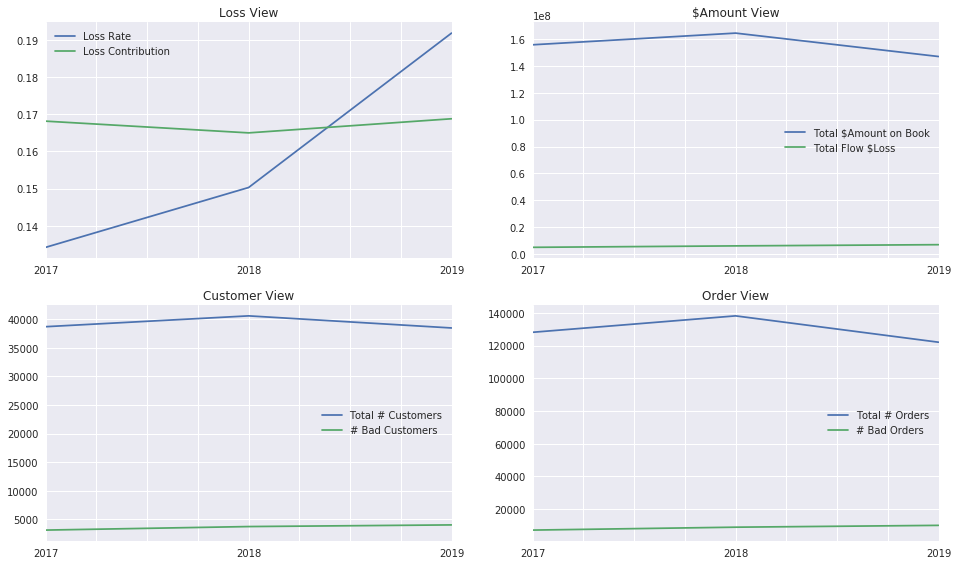

*===============================================================================================================*
						 THE HOME DEPOT
*===============================================================================================================*


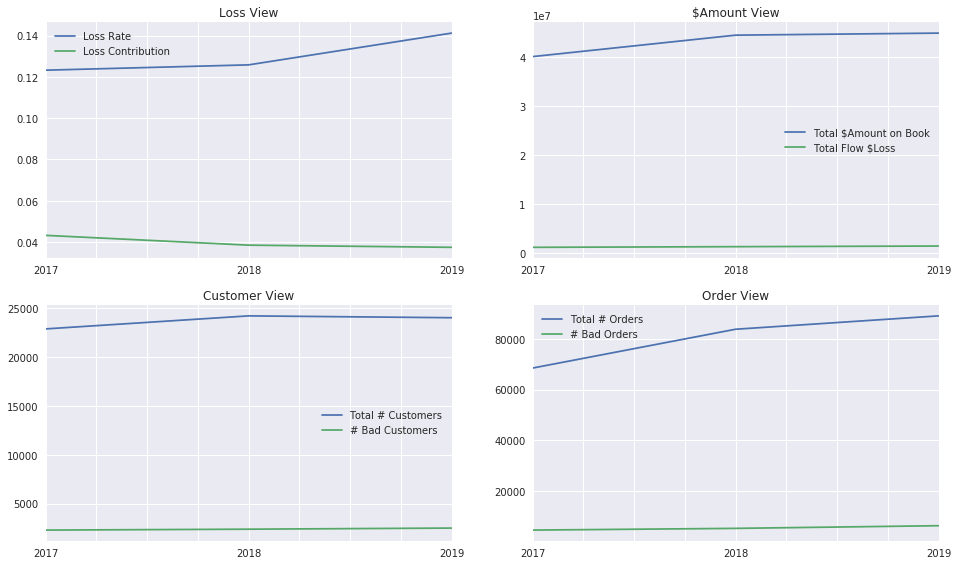

*===============================================================================================================*
						 DAVITA INC
*===============================================================================================================*


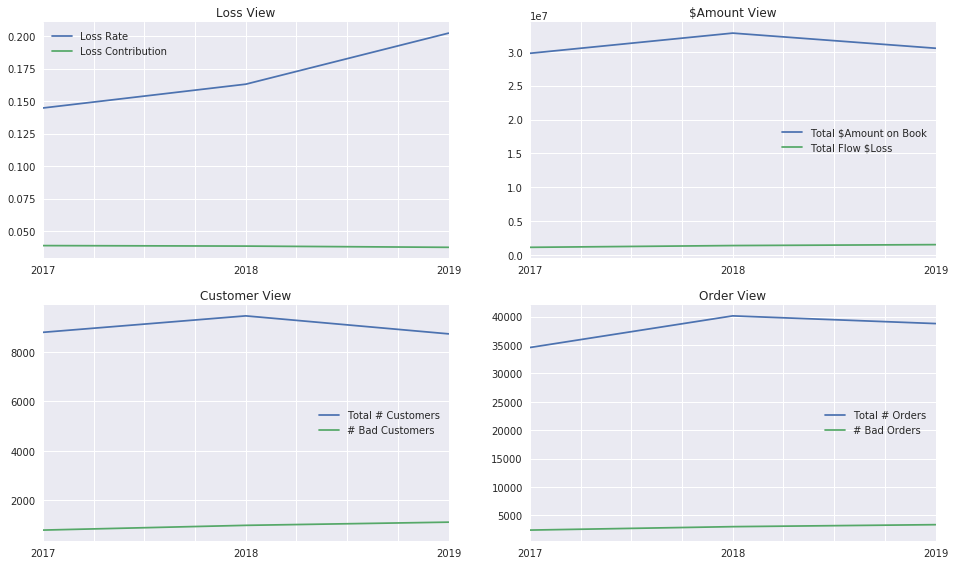

*===============================================================================================================*
						 TYSON FOODS
*===============================================================================================================*


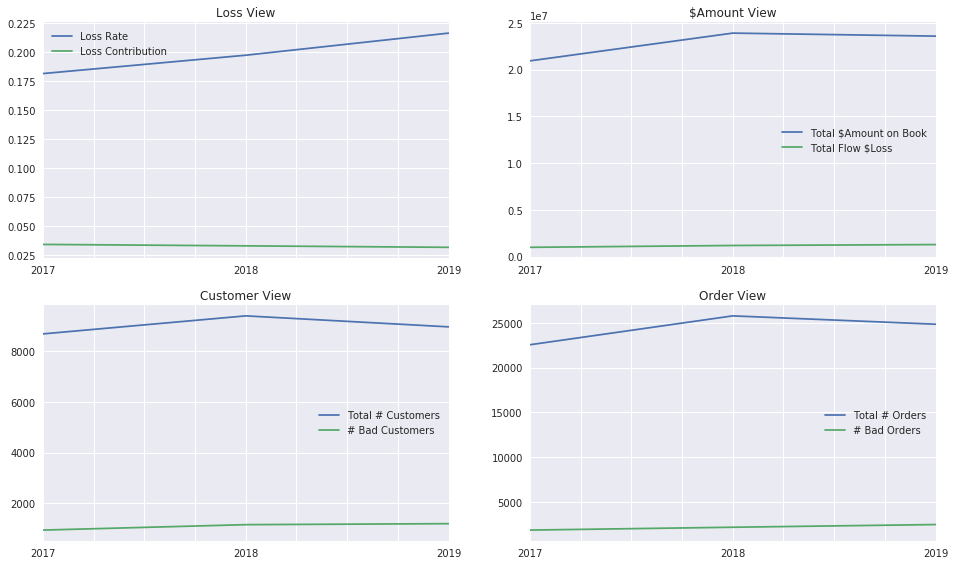

*===============================================================================================================*
						 COMMUNITY HEALTH SYSTEMS
*===============================================================================================================*


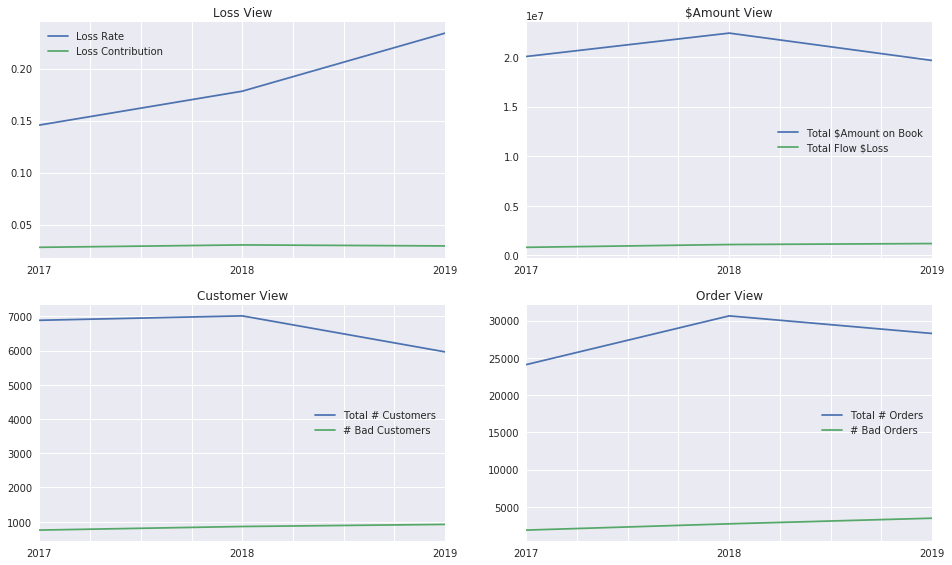

*===============================================================================================================*
						 SEANC
*===============================================================================================================*


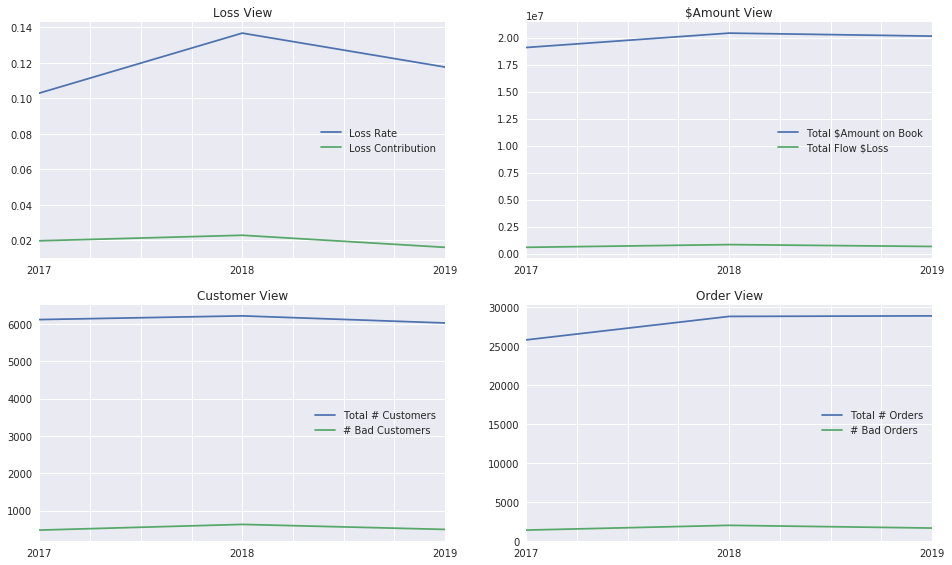

*===============================================================================================================*
						 KOHL'S DEPARTMENT STORES
*===============================================================================================================*


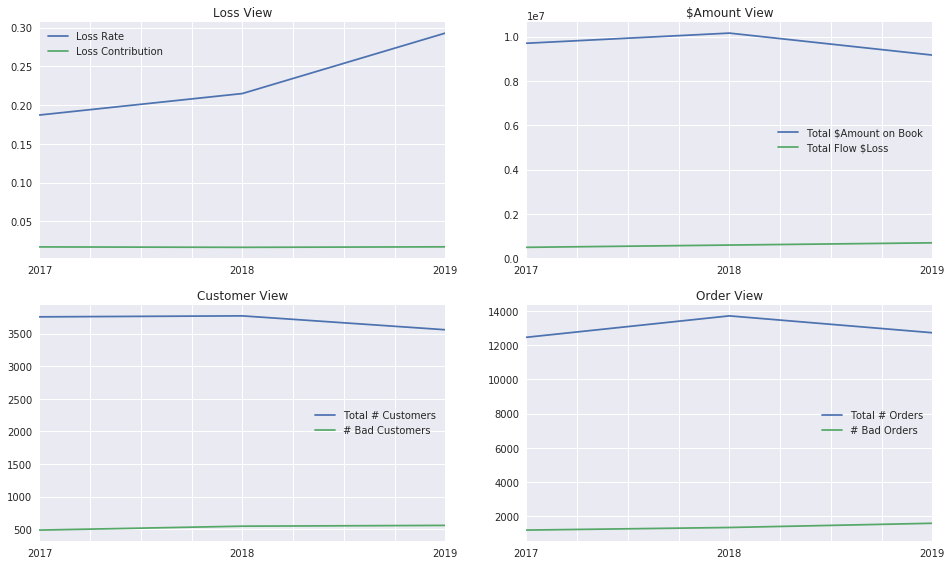

*===============================================================================================================*
						 CALIFORNIA STATE EMPLOYEES ASSOCIATION
*===============================================================================================================*


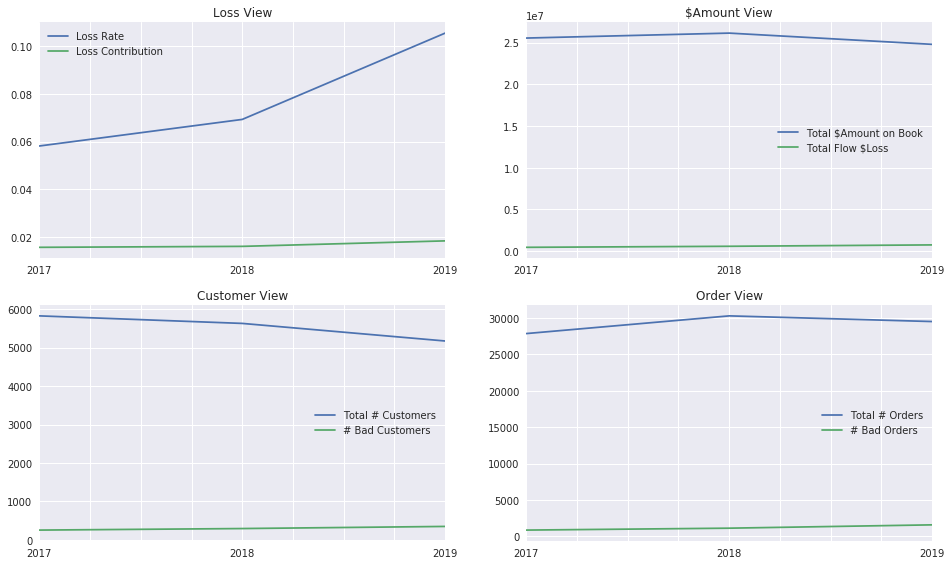

*===============================================================================================================*
						 DELTA AIR LINES, INC.
*===============================================================================================================*


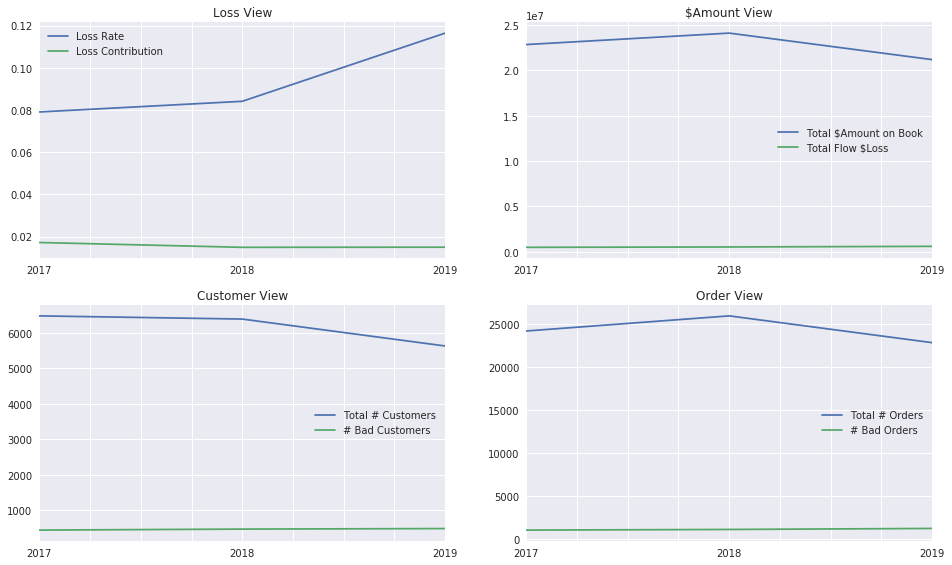

*===============================================================================================================*
						 AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES
*===============================================================================================================*


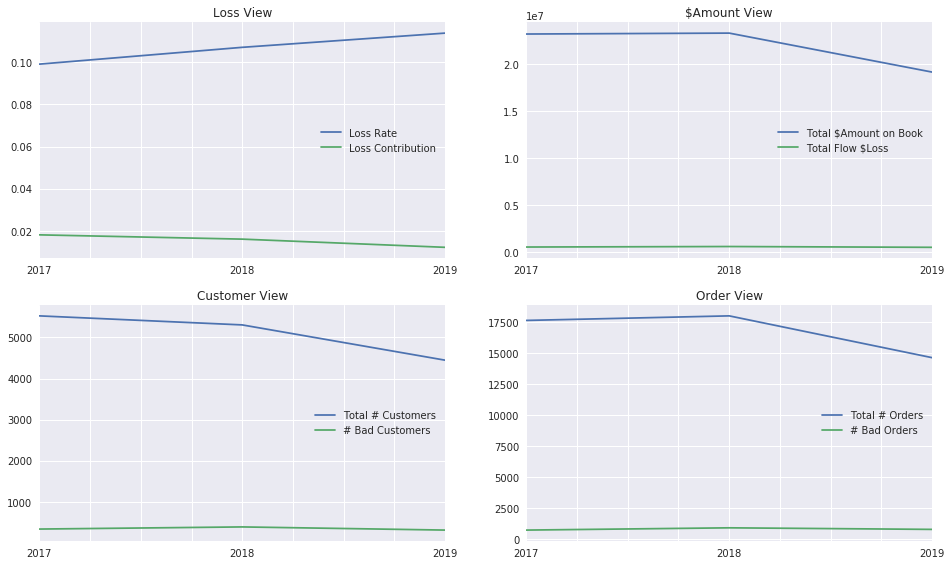

In [108]:
list_of_client_ids =[2049, 2302, 2250, 2149, 2422, 2191, 2225, 2183, 2238, 2047]#, 2496, 2218, 2400]
print('\t\t\t\t*=============================================*')
print('\t\t\t\tTop 10 Avg Loss Contribution over past 3 years')
print('\t\t\t\t*=============================================*')
# Client View
for client_id in list_of_client_ids:
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (16,9))
    plt.subplots_adjust(left = 0.125,
                        right = 0.9,
                        bottom = 0.1,
                        top = 0.9,
                        wspace = 0.2,
                        hspace = 0.2)
    acct_name = loss_rate[loss_rate['Client ID']==client_id]['Account Name'].values[0]
    print('*===============================================================================================================*')
    print('\t\t\t\t\t\t',acct_name)
    print('*===============================================================================================================*')

        
    loss_rate[loss_rate['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,0])
    loss_contrib[loss_contrib['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,0])
    axes[0,0].legend(['Loss Rate','Loss Contribution'])
    axes[0,0].set_title('Loss View')
    
    total_amt_ob[total_amt_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
    flow_loss[flow_loss['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
    axes[0,1].legend(['Total $Amount on Book','Total Flow $Loss'])
    axes[0,1].set_title('$Amount View')
    
    
    total_cust_ob[total_cust_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    flow_cust[flow_cust['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    axes[1,0].legend(['Total # Customers','# Bad Customers'])
    axes[1,0].set_title('Customer View')
    
    total_ord_ob[total_ord_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,1])
    flow_ord[flow_ord['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,1])
    axes[1,1].legend(['Total # Orders','# Bad Orders'])
    axes[1,1].set_title('Order View')
    
    plt.show()

					*====================================*
					Top 10 Avg Loss Rate over past 3 years
					*====================================*
*===============================================================================================================*
						 BOEING (RETIREES)
*===============================================================================================================*


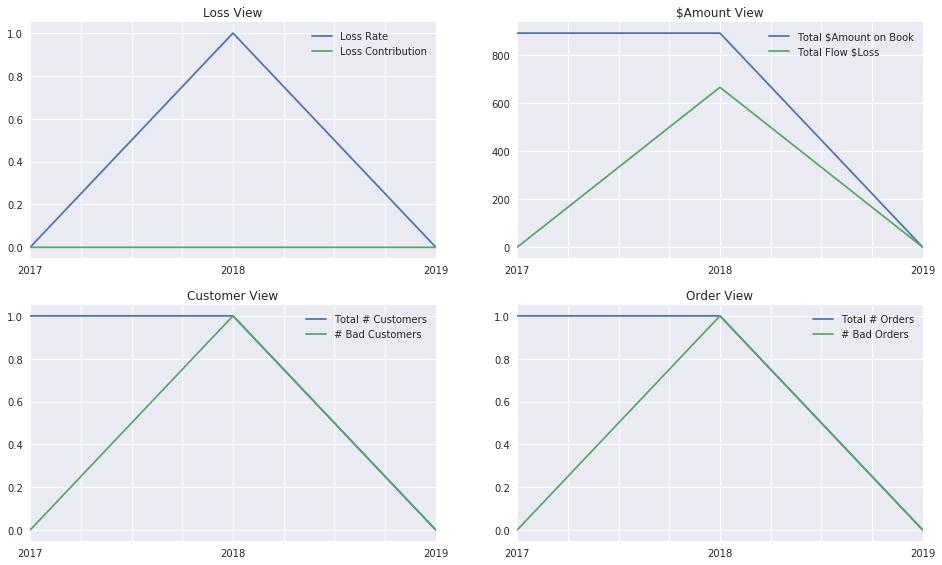

*===============================================================================================================*
						 MERCER MARKETPLACE
*===============================================================================================================*


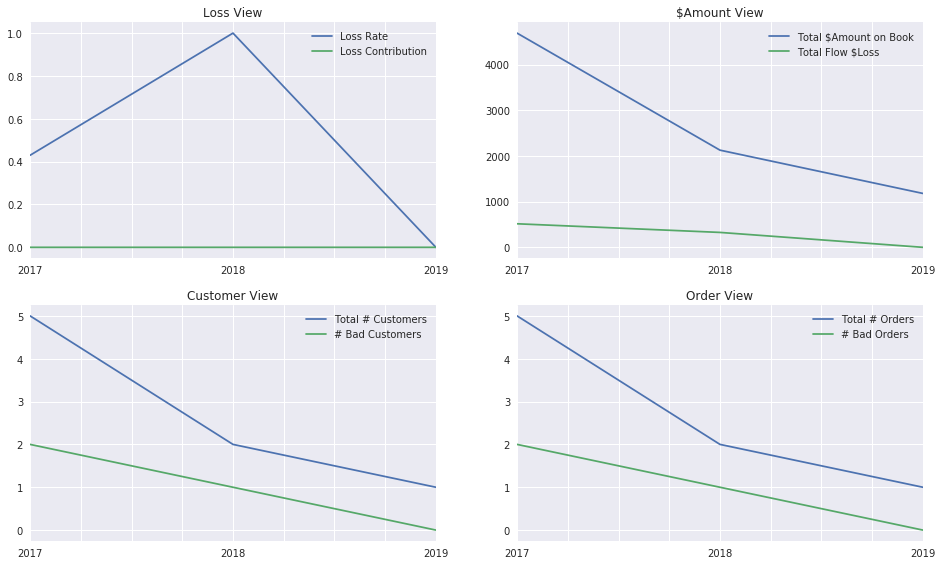

*===============================================================================================================*
						 DEKALB COUNTY GOVERNMENT
*===============================================================================================================*


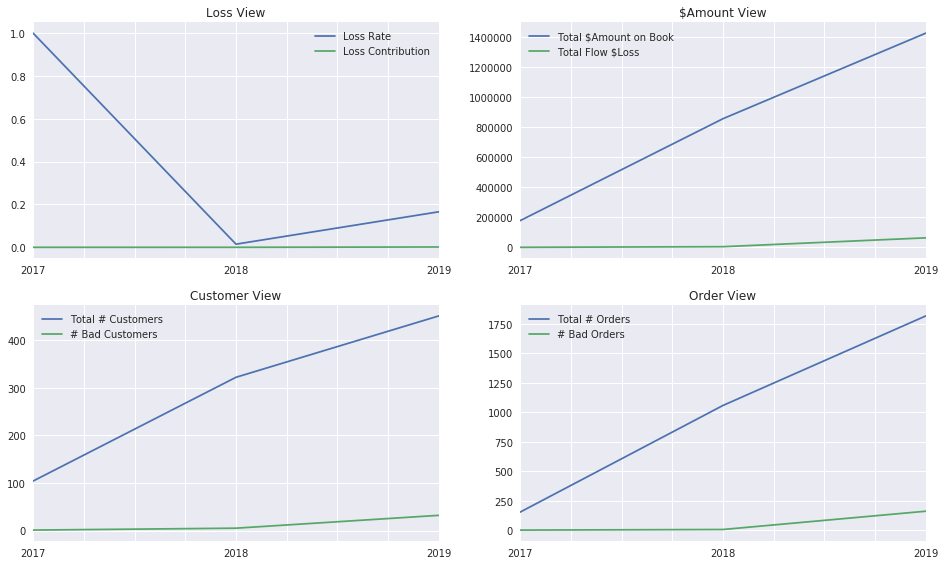

*===============================================================================================================*
						 FEDERAL FIRST
*===============================================================================================================*


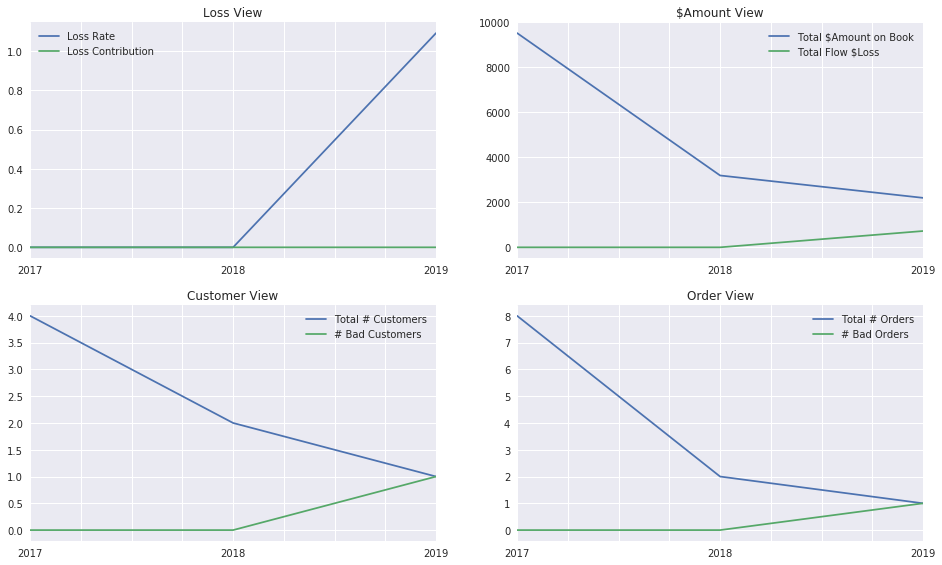

*===============================================================================================================*
						 AUGEO AFFINITY MARKETING, INC
*===============================================================================================================*


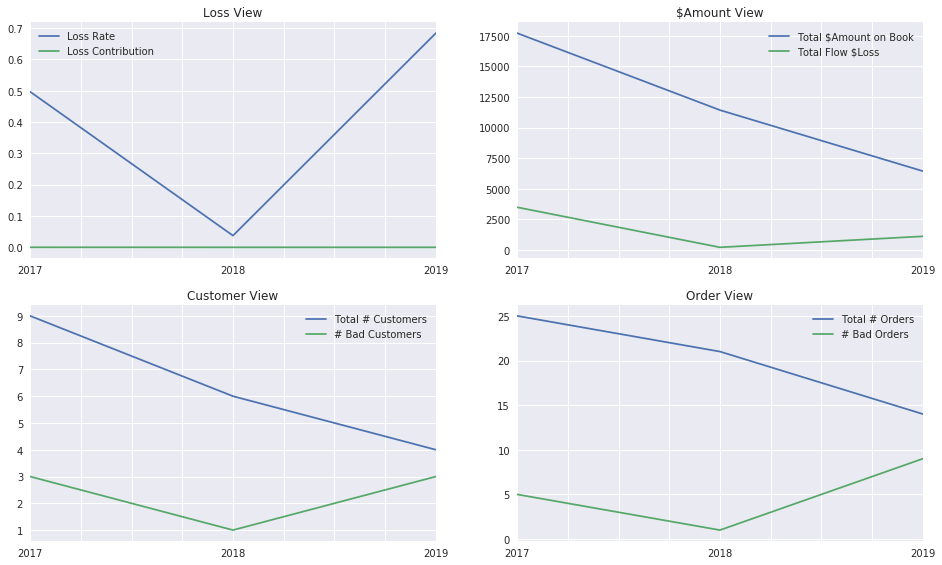

*===============================================================================================================*
						 WALGREENS PART-TIME
*===============================================================================================================*


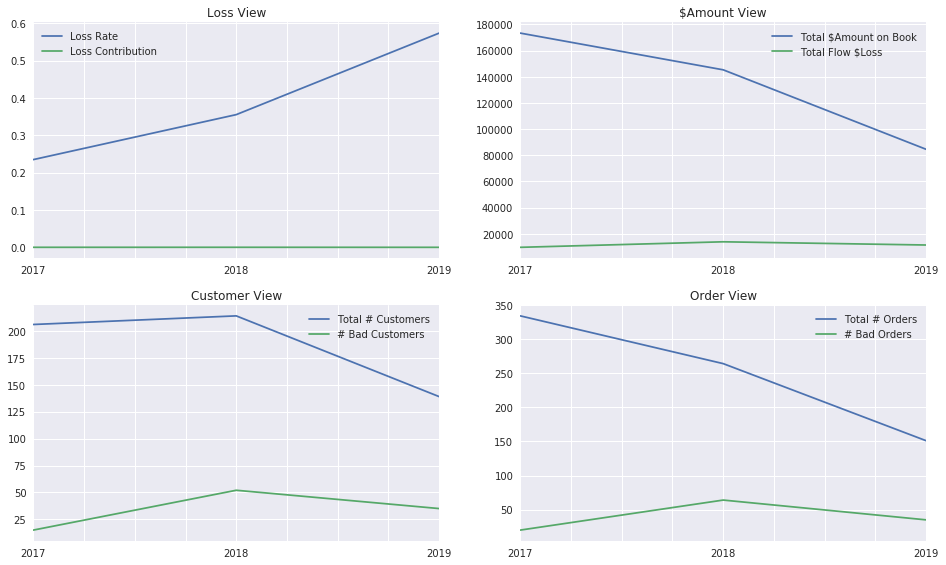

*===============================================================================================================*
						 SERCO
*===============================================================================================================*


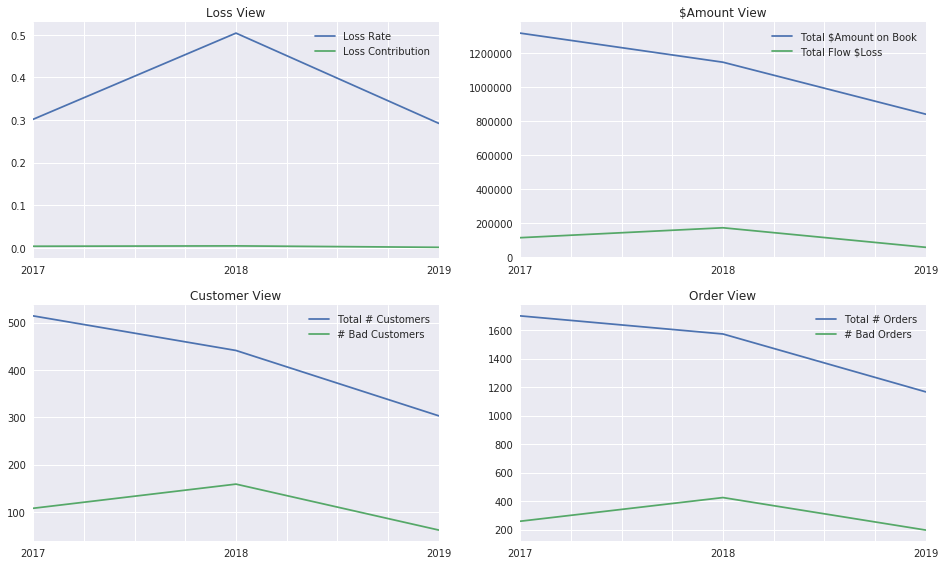

*===============================================================================================================*
						 FAZOLI'S SYSTEM MGMT
*===============================================================================================================*


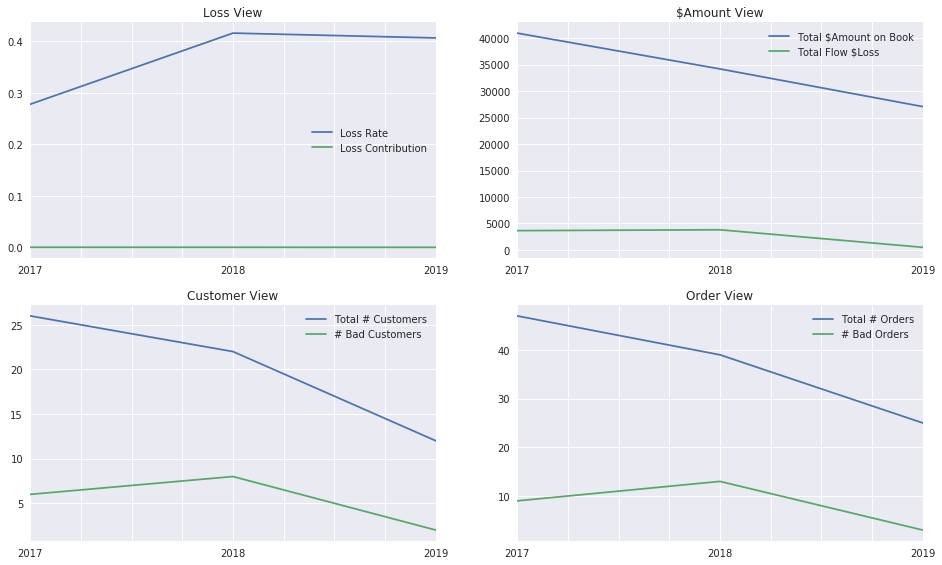

*===============================================================================================================*
						 ALPHASTAFF, INC.
*===============================================================================================================*


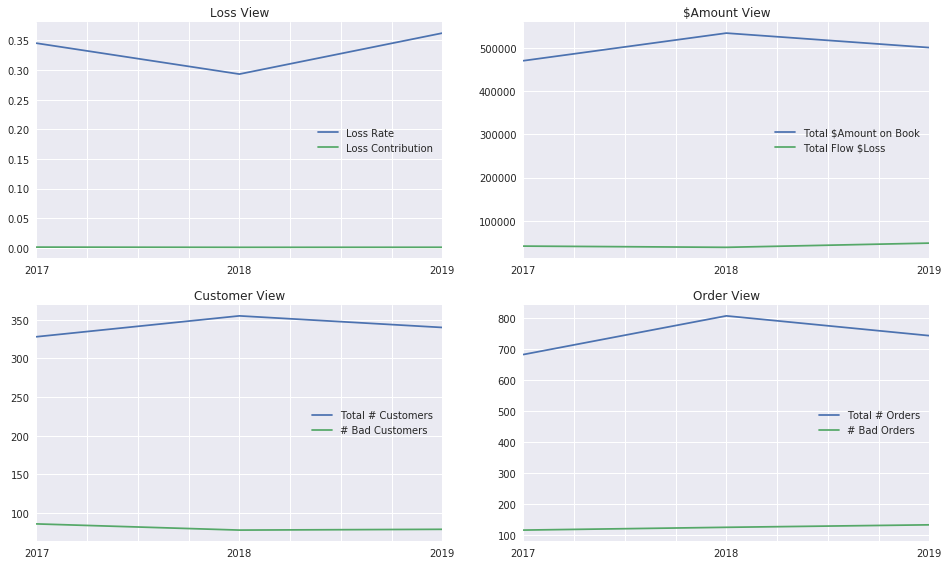

*===============================================================================================================*
						 CAPSTONE RESTAURANT GROUP
*===============================================================================================================*


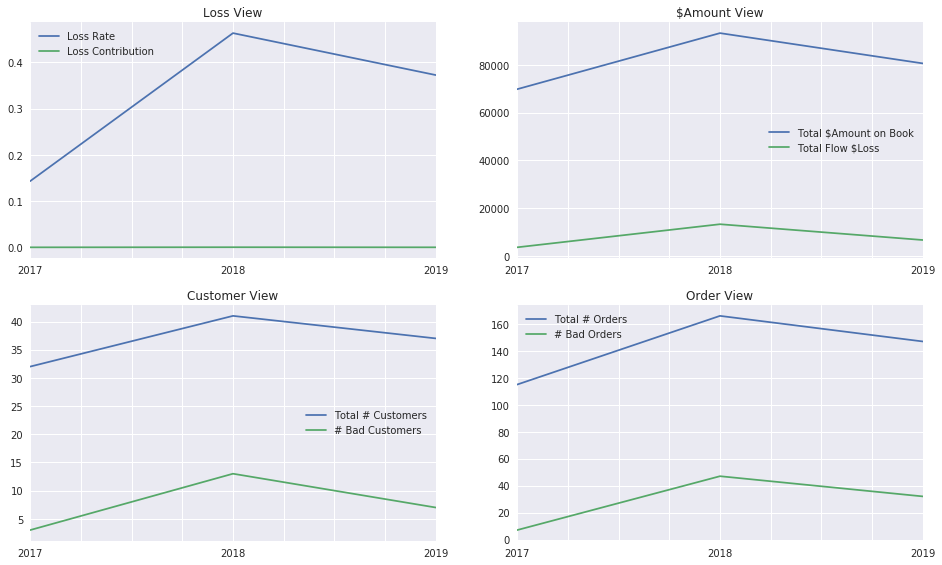

In [107]:
list_of_client_ids = [5001, 2406, 2506, 2854, 4022, 2401, 2351, 2254, 2221, 2466]
print('\t\t\t\t\t*====================================*')
print('\t\t\t\t\tTop 10 Avg Loss Rate over past 3 years')
print('\t\t\t\t\t*====================================*')

# Client View
for client_id in list_of_client_ids:
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (16,9))
    plt.subplots_adjust(left = 0.125,
                        right = 0.9,
                        bottom = 0.1,
                        top = 0.9,
                        wspace = 0.2,
                        hspace = 0.2)
    acct_name = loss_rate[loss_rate['Client ID']==client_id]['Account Name'].values[0]
    print('*===============================================================================================================*')
    print('\t\t\t\t\t\t',acct_name)
    print('*===============================================================================================================*')

        
    loss_rate[loss_rate['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,0])
    loss_contrib[loss_contrib['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,0])
    axes[0,0].legend(['Loss Rate','Loss Contribution'])
    axes[0,0].set_title('Loss View')
    
    total_amt_ob[total_amt_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
    flow_loss[flow_loss['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
    axes[0,1].legend(['Total $Amount on Book','Total Flow $Loss'])
    axes[0,1].set_title('$Amount View')
    
    
    total_cust_ob[total_cust_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    flow_cust[flow_cust['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    axes[1,0].legend(['Total # Customers','# Bad Customers'])
    axes[1,0].set_title('Customer View')
    
    total_ord_ob[total_ord_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,1])
    flow_ord[flow_ord['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,1])
    axes[1,1].legend(['Total # Orders','# Bad Orders'])
    axes[1,1].set_title('Order View')
    
    plt.show()

*===============================================================================================================*
					Top 5 Loss Contribution Clients
*===============================================================================================================*


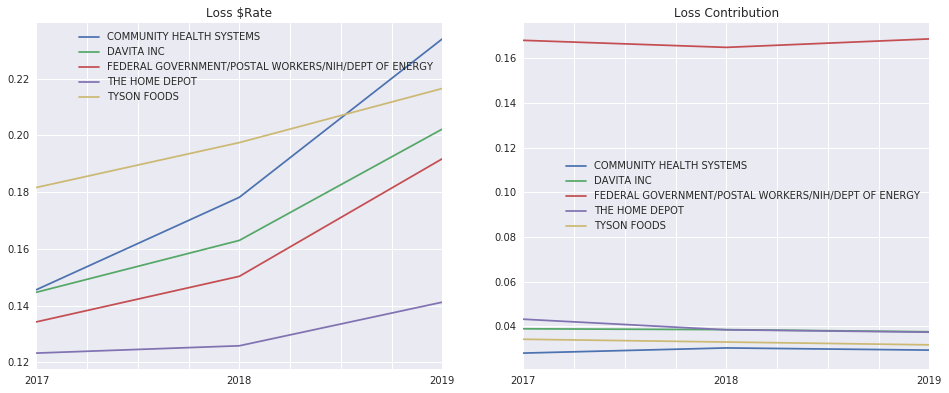

In [109]:
top5_client_ids =[2049, 2302, 2250, 2149, 2422]
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
plt.subplots_adjust(left = 0.125,
                    right = 0.9,
                    bottom = 0.1,
                    top = 0.9,
                    wspace = 0.2,
                    hspace = 0.2)
acct_name = [loss_rate[loss_rate['Client ID']==i]['Account Name'].values[0] for i in top5_client_ids]
print('*===============================================================================================================*')
# print('\t\t\t\t\t\t',acct_name)
print('\t\t\t\t\tTop 5 Loss Contribution Clients')
print('*===============================================================================================================*')


loss_rate[loss_rate['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[0])

axes[0].legend()
axes[0].set_title('Loss $Rate')


loss_contrib[loss_contrib['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[1])
axes[1].legend()
axes[1].set_title('Loss Contribution')

plt.show()

*===============================================================================================================*
					Top 2-5 Loss Contribution Clients
*===============================================================================================================*


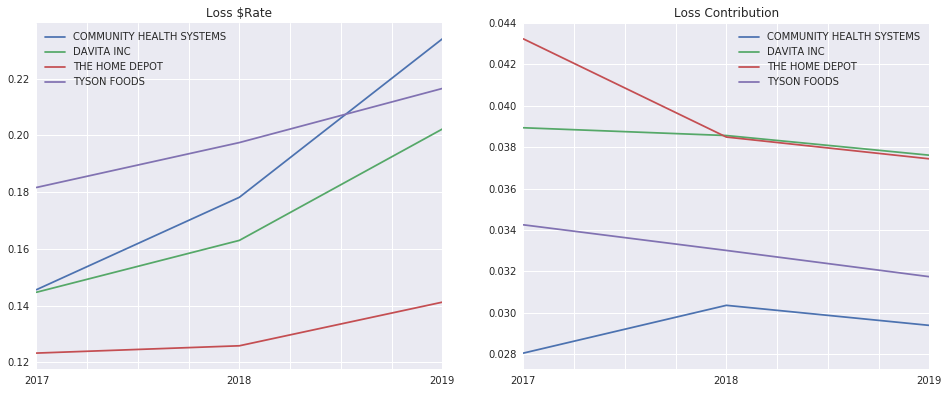

In [110]:
top2_to_5_client_ids =[2302, 2250, 2149, 2422]
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
plt.subplots_adjust(left = 0.125,
                    right = 0.9,
                    bottom = 0.1,
                    top = 0.9,
                    wspace = 0.2,
                    hspace = 0.2)
acct_name = [loss_rate[loss_rate['Client ID']==i]['Account Name'].values[0] for i in top2_to_5_client_ids]
print('*===============================================================================================================*')
# print('\t\t\t\t\t\t',acct_name)
print('\t\t\t\t\tTop 2-5 Loss Contribution Clients')
print('*===============================================================================================================*')


loss_rate[loss_rate['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[0])

axes[0].legend()
axes[0].set_title('Loss $Rate')


loss_contrib[loss_contrib['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[1])
axes[1].legend()
axes[1].set_title('Loss Contribution')


plt.show()

*===============================================================================================================*
					Top 5-10 Loss Contribution Clients
*===============================================================================================================*


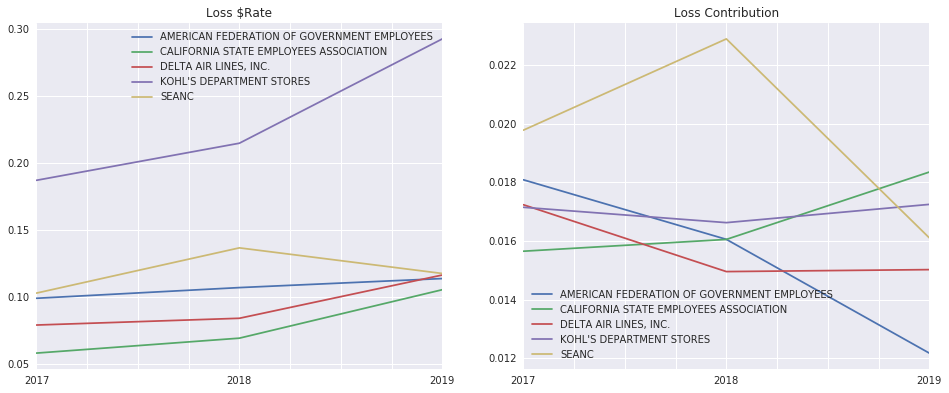

In [111]:
top5_to_10_client_ids = [2191, 2225, 2183, 2238, 2047]
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
plt.subplots_adjust(left = 0.125,
                    right = 0.9,
                    bottom = 0.1,
                    top = 0.9,
                    wspace = 0.2,
                    hspace = 0.2)
acct_name = [loss_rate[loss_rate['Client ID']==i]['Account Name'].values[0] for i in top5_to_10_client_ids]
print('*===============================================================================================================*')
# print('\t\t\t\t\t\t',acct_name)
print('\t\t\t\t\tTop 5-10 Loss Contribution Clients')
print('*===============================================================================================================*')


loss_rate[loss_rate['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[0])

axes[0].legend()
axes[0].set_title('Loss $Rate')


loss_contrib[loss_contrib['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[1])
axes[1].legend()
axes[1].set_title('Loss Contribution')


plt.show()

*===============================================================================================================*
					Top 10-13 Loss Contribution Clients
*===============================================================================================================*


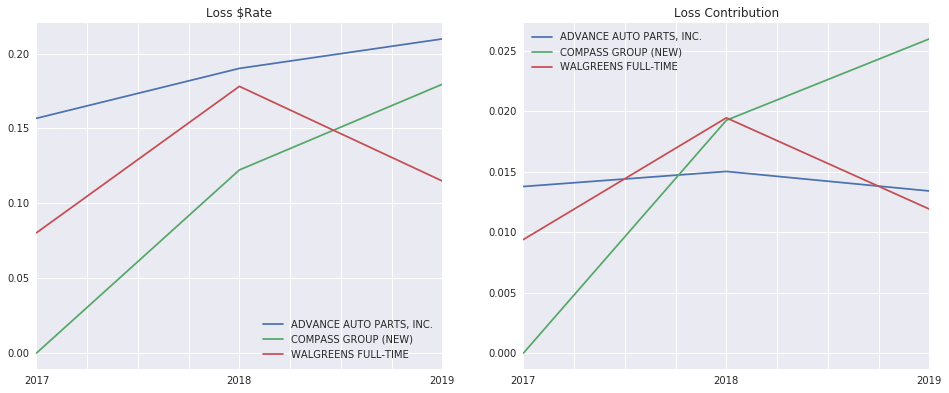

In [112]:
top10_to_13_client_ids = [2496, 2218, 2400]
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
plt.subplots_adjust(left = 0.125,
                    right = 0.9,
                    bottom = 0.1,
                    top = 0.9,
                    wspace = 0.2,
                    hspace = 0.2)
acct_name = [loss_rate[loss_rate['Client ID']==i]['Account Name'].values[0] for i in top10_to_13_client_ids]
print('*===============================================================================================================*')
# print('\t\t\t\t\t\t',acct_name)
print('\t\t\t\t\tTop 10-13 Loss Contribution Clients')
print('*===============================================================================================================*')


loss_rate[loss_rate['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[0])

axes[0].legend()
axes[0].set_title('Loss $Rate')


loss_contrib[loss_contrib['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[1])
axes[1].legend()
axes[1].set_title('Loss Contribution')


plt.show()

In [114]:
list_of_client_ids =[2049, 2302, 2250, 2149, 2422, 2191, 2225, 2183, 2238, 2047, 2496, 2218, 2400]
for client_id in list_of_client_ids:
    acct_name = Client[Client['Client ID']==client_id]['Account Name'].values[0]
    print('\n*===============================================*')
    print(acct_name)
    print('*===============================================*')


    df = df_17[df_17['Unique_Company_ID']==client_id]
    df_bad = df[(df['Bad']==1) & (df['Ever_Bad']<=1)]
    df_good = df.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)
    print('\t\t*============*')
    print('\t\tGood Customers')
    print('\t\t*============*')
    print(df_good.groupby(['Year','Status']).agg({'Unique_Customer_ID':'nunique'}))
    print('\t\t*============*')
    print('\t\tBad Customers')
    print('\t\t*============*')
    print(df_bad.groupby(['Year','Status']).agg({'Unique_Customer_ID':'nunique'}))


*===============================================*
FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY
*===============================================*
		*============*
		Good Customers
		*============*
                  Unique_Customer_ID
Year Status                         
2017 DECEASED                     18
     DIRECT BILL                 376
     EMPLOYED                  32319
     TERMINATED                    1
2018 DECEASED                      9
     DIRECT BILL                  50
     EMPLOYED                  33823
     TERMINATED                    1
2019 DECEASED                      3
     DIRECT BILL                   1
     EMPLOYED                  33329
		*============*
		Bad Customers
		*============*
                  Unique_Customer_ID
Year Status                         
2017 DECEASED                     16
     DIRECT BILL                1708
     EMPLOYED                   1425
     TERMINATED                    1
2018 DECEASED                     14
     

		*============*
		Good Customers
		*============*
                  Unique_Customer_ID
Year Status                         
2017 DECEASED                      1
     DIRECT BILL                 415
     EMPLOYED                   1979
     LOA                          23
     TERMINATED                  506
2018 DIRECT BILL                 256
     EMPLOYED                   2202
     LOA                          25
     TERMINATED                  436
2019 DIRECT BILL                  90
     EMPLOYED                   2469
     LOA                          31
     TERMINATED                  289
		*============*
		Bad Customers
		*============*
                  Unique_Customer_ID
Year Status                         
2017 DECEASED                      1
     DIRECT BILL                  93
     EMPLOYED                     19
     LOA                           1
     TERMINATED                  371
2018 DECEASED                      2
     DIRECT BILL                 407
     EMPLOY

In [ ]:
# list_of_client_ids =[2049, 2302, 2250, 2149, 2422, 2191, 2225, 2183, 2238, 2047, 2496, 2218, 2400]

# print('\t\t\t\t*=============================================*')
# print('\t\t\t\tTop Loss Contribution(13) over past 3 years')
# print('\t\t\t\t*=============================================*')
# # Client View
# for client_id in list_of_client_ids:
#     fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (16,9))
#     plt.subplots_adjust(left = 0.125,
#                         right = 0.9,
#                         bottom = 0.1,
#                         top = 0.9,
#                         wspace = 0.2,
#                         hspace = 0.4)
#     df = df_17[df_17['Unique_Company_ID']==client_id]
#     df_bad = df[(df['Bad']==1) & (df['Ever_Bad']<=1)]
#     df_good = df.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)
#     rest = df_17[df_17['Unique_Company_ID']!=client_id]
#     acct_name = Client[Client['Client ID']==client_id]['Account Name'].values[0]
#     print('*===============================================================================================================*')
#     print('\t\t\t\t\t\t',acct_name)
#     print('*===============================================================================================================*')

#     df_bad.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax=axes[0,0])
#     df_good.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax=axes[0,0])
#     rest.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax = axes[0,0])
#     axes[0,0].legend(['Bad','Good','Other'])
#     axes[0,0].set_title('Avg Assigned Spending Limit')
    
#     (df_bad.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
#                 aggfunc='mean')/df_bad.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
#                 aggfunc='mean')).plot(ax=axes[0,1])

#     (df_good.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
#                 aggfunc='mean')/df_good.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
#                 aggfunc='mean')).plot(ax=axes[0,1])
#     axes[0,1].legend(['Bad','Good'])
#     axes[0,1].set_title('Avg Order Amt over Spending Limit')
    
#     df_bad.groupby('Year_and_Month').agg({'Customer_Tenure':'mean'}).plot(ax=axes[1,0])
#     df_good.groupby('Year_and_Month').agg({'Customer_Tenure':'mean'}).plot(ax=axes[1,0])
#     axes[1,0].legend(['Bad','Good'])
#     axes[1,0].set_title('Avg Customer Tenure')
    
#     df_bad.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1,1])
#     df_good.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1,1])
#     rest.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1,1])
#     axes[1,1].legend(['Bad','Good','Other'])
#     axes[1,1].set_title('Avg Customer Salary')
    
    
#     print(df_bad.groupby(['Status']).agg({'Unique_Customer_ID':'nunique'}))
    
#     plt.show()

## 6. Vintage View

### 6.1 Vintage pbads Rate View

In [115]:
YQ_list = Perf[Perf['YQ']>='2015Q1']['YQ'].unique()
# x = Perf.loc[Perf.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]
Vintage = Perf[Perf['Payment_Order']==1]

In [147]:
def vintage_view(df, YQ, vintage):
    # Get the performance data of orders that were made at this specific Y_Q 
    order_list = vintage[vintage['YQ'] == YQ]['Unique_Order_ID'].tolist()
    df_YQ = df[df['Unique_Order_ID'].isin(order_list)]
    
    # Get the CO orders
    df_DQ = df_YQ[(df_YQ['Bad']==1) & (df_YQ['Ever_Bad']<=1)]
    # Calculate number of CO orders by Year_and_Month
    view = df_DQ.groupby('Year_and_Month')['Unique_Order_ID'].size().reset_index()
    # Assign month_order
    temp = pd.DataFrame({'month_order': np.arange(1, 31), 'Year_and_Month': np.array(
        pd.date_range(start=YQ.to_timestamp(), periods=30, freq='MS'))})
    view = temp.merge(view, how = 'left',on='Year_and_Month')
    # Create cumulatvie number of CO orders and DQ_Rate
    view = view.fillna(0)
    view['count'] = view['Unique_Order_ID'].cumsum()
    view['DQ_Rate'] = view['count']/len(order_list)

    view.rename(columns={'DQ_Rate': str(YQ)+'_Vintage'}, inplace=True)
    return view

In [148]:
# Q1
Q1_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[i*4])
    view = vintage_view(Perf, YQ_list[i*4], Vintage)    
    Q1_vintage_list.append(view[['month_order',str(YQ_list[i*4])+'_Vintage']])

2015Q1
2016Q1
2017Q1
2018Q1
2019Q1


In [122]:
# Q2
Q2_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[1+i*4])
    view = vintage_view(Perf, YQ_list[1+i*4], Vintage)
    Q2_vintage_list.append(view[['month_order',str(YQ_list[1+i*4])+'_Vintage']])

2015Q2
2016Q2
2017Q2
2018Q2
2019Q2


In [123]:
# Q3
Q3_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[2+i*4])
    view = vintage_view(Perf, YQ_list[2+i*4], Vintage)
    Q3_vintage_list.append(view[['month_order',str(YQ_list[2+i*4])+'_Vintage']])

2015Q3
2016Q3
2017Q3
2018Q3
2019Q3


In [124]:
# Q4
Q4_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[3+i*4])
    view = vintage_view(Perf, YQ_list[3+i*4], Vintage)
    Q4_vintage_list.append(view[['month_order',str(YQ_list[3+i*4])+'_Vintage']])

2015Q4
2016Q4
2017Q4
2018Q4
2019Q4


In [149]:
Q1_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q1_vintage_list)
Q2_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q2_vintage_list)
Q3_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q3_vintage_list)
Q4_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q4_vintage_list)

In [150]:
Q1_final

,month_order,2015Q1_Vintage,2016Q1_Vintage,2017Q1_Vintage,2018Q1_Vintage,2019Q1_Vintage
0,1,0.000000,0.000000,0.000000,0.000068,0.000000
1,2,0.000000,0.000000,0.000011,0.000101,0.000000
2,3,0.000000,0.000026,0.000011,0.000118,0.000000
3,4,0.000000,0.000026,0.000011,0.000118,0.000000
4,5,0.000000,0.000026,0.000011,0.000127,0.000000
5,6,0.000076,0.000092,0.000199,0.000262,0.000149
6,7,0.001866,0.002165,0.002008,0.002536,0.003061
7,8,0.008703,0.009268,0.009949,0.010669,0.013009
8,9,0.021500,0.022589,0.024124,0.025827,0.030904
9,10,0.035611,0.036821,0.040559,0.044689,0.049762


In [ ]:
Q1_final.to_csv('../data/Q1.csv',index = False)
Q2_final.to_csv('../data/Q2.csv',index = False)
Q3_final.to_csv('../data/Q3.csv',index = False)
Q4_final.to_csv('../data/Q4.csv',index = False)

### 6.2 Vintage $ Loss Rate View

In [127]:
def vintage_dollar_view(df, YQ, vintage):
    # Get the performance data of orders that were made at this specific Y_Q 
    order_list = vintage[vintage['YQ'] == YQ]['Unique_Order_ID'].tolist()
    total_balance = vintage[vintage['YQ'] == YQ]['Current_Balance'].sum()
    df_YQ = df[df['Unique_Order_ID'].isin(order_list)]
    
    # Get the CO orders
    df_DQ = df_YQ[(df_YQ['Bad']==1) & (df_YQ['Ever_Bad']<=1)]
    
    # Calculate total loss of CO orders by Year_and_Month
    view = df_DQ.groupby('Year_and_Month').agg({'2os_loss':'sum'}).reset_index()
    temp = pd.DataFrame({'month_order': np.arange(1, 31), 'Year_and_Month': np.array(
        pd.date_range(start=YQ.to_timestamp(), periods=30, freq='MS'))})
    view = temp.merge(view, how = 'left',on='Year_and_Month')
    view = view.fillna(0)
    # Calculate the cumulative loss as DQ_Balance
    view['DQ_Balance'] = view['2os_loss'].cumsum()
    view['DQ_Rate'] = view['DQ_Balance']/total_balance

    view.rename(columns = {'DQ_Rate':str(YQ)+'_Vintage'},inplace = True)
    return view

In [128]:
# Q1
# temp = pd.DataFrame(np.arange(1,31),columns = ['month_order'])
Q1_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[i*4])
    view = vintage_dollar_view(Perf, YQ_list[i*4], Vintage)
    Q1_vintage_list.append(view[['month_order',str(YQ_list[i*4])+'_Vintage']])

2015Q1
2016Q1
2017Q1
2018Q1
2019Q1


In [129]:
# Q2
Q2_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[1+i*4])
    view = vintage_dollar_view(Perf, YQ_list[1+i*4], Vintage)
    Q2_vintage_list.append(view[['month_order',str(YQ_list[1+i*4])+'_Vintage']])

2015Q2
2016Q2
2017Q2
2018Q2
2019Q2


In [130]:
# Q3
Q3_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[2+i*4])
    view = vintage_dollar_view(Perf, YQ_list[2+i*4], Vintage)
    Q3_vintage_list.append(view[['month_order',str(YQ_list[2+i*4])+'_Vintage']])

2015Q3
2016Q3
2017Q3
2018Q3
2019Q3


In [131]:
# Q4
Q4_vintage_list = []
for i in range(int(len(YQ_list)/4)-1):
    print(YQ_list[3+i*4])
    view = vintage_dollar_view(Perf, YQ_list[3+i*4], Vintage)
    Q4_vintage_list.append(view[['month_order',str(YQ_list[3+i*4])+'_Vintage']])

2015Q4
2016Q4
2017Q4
2018Q4


In [132]:
Q1_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q1_vintage_list)
Q2_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q2_vintage_list)
Q3_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q3_vintage_list)
Q4_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q4_vintage_list)

In [136]:
Q4_final

,month_order,2015Q4_Vintage,2016Q4_Vintage,2017Q4_Vintage,2018Q4_Vintage
0,1,0.000000,0.000022,0.000000,0.000000
1,2,0.000000,0.000022,0.000000,0.000000
2,3,0.000000,0.000048,0.000006,0.000000
3,4,0.000000,0.000051,0.000014,0.000014
4,5,0.000000,0.000051,0.000030,0.000025
5,6,0.000097,0.000085,0.000053,0.000133
6,7,0.000936,0.001176,0.001012,0.001449
7,8,0.004364,0.005221,0.005047,0.007171
8,9,0.010663,0.012211,0.013607,0.018015
9,10,0.019784,0.023424,0.025350,0.033540


In [21]:
Q1_final.to_csv('../data/Q1_Dollar.csv',index = False)
Q2_final.to_csv('../data/Q2_Dollar.csv',index = False)
Q3_final.to_csv('../data/Q3_Dollar.csv',index = False)
Q4_final.to_csv('../data/Q4_Dollar.csv',index = False)